# Предсказание увольнения сотрудника

Необходимо создать модели для предсказания удовлетворённостью работой и вероятностью увольнения сотрудников.

## Цель
С помощью модели необходимо предсказывать удовлетворённость и вероятность ухода из компании сотрудников:
 - выбрать алгоритм и обучить модель регрессии, предсказвающую удовлетворённость сотрудника своим местом работы;
 - выбрать алгоритм и обучить модель классификации, предсказывающую увольнение сотрундика;
 - исследовать связь удовлетворённости рабочим местом и вероятностью его увольнения
 - построить основную уточнённую модель предсказания вероятности увольнения сотрудника 
 - дать рекомендации по повышению удовлетворённости сотрудников работой и их удержанию в компании

## Описание данных:
### Характеристики сотрудника
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.
### Увольнение сотрудника
- `id` — уникальный идентификатор сотрудника;
- `quit` — признак увольнения сотрудника.

## План исследования

1) Предобработка данных
2) Исследовательский анализ данных
3) Корреляционный анализ
4) Построение пайплайнов для выбора лучшей модели регрессии
5) Анализ важности признаков регрессии
6) Создание personality уволившегося сотрудника 
6) Построение основной уточнённой модели предсказания вероятности увольнения сотрудника
7) Анализ важности признаков улучшенной модели
8) Предложения по повышению удовлетворённости сотрудников работой и их удержанию в компании
9) Общий вывод

##  Предобработка данных

### Импорт модулей

! pip install shap
! pip install phik

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
import seaborn as sns
from typing import Optional
import random
import phik
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance
from statsmodels.tools.tools import add_constant

Определение констант

In [2]:
RANDOM_STATE = 1

Загрузка данных

In [3]:
try:
    X_test = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_2_HR_Analytics\source\test_features.csv")
    y_test_classif = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_2_HR_Analytics\source\test_target_quit.csv")
    y_test_regress = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_2_HR_Analytics\source\test_target_job_satisfaction_rate.csv")
    X_train_js = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_2_HR_Analytics\source\train_job_satisfaction_rate.csv")
    X_train_q = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_2_HR_Analytics\source\train_quit.csv")
except:
    X_test = pd.read_csv(r"/datasets/test_features.csv")
    y_test_classif = pd.read_csv(r"/datasets/test_target_quit.csv")
    y_test_regress = pd.read_csv(r"/datasets/test_target_job_satisfaction_rate.csv")
    X_train_js = pd.read_csv(r"/datasets/train_job_satisfaction_rate.csv")
    X_train_q = pd.read_csv(r"/datasets/train_quit.csv")

pd.set_option('display.max_columns', None)

display(X_test.head(20))
display(y_test_classif.head(20))
display(y_test_regress.head(20))
display(X_train_js.head(20))
display(X_train_q.head(20))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


In [4]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [5]:
y_test_classif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [6]:
y_test_regress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [7]:
X_train_js.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [8]:
X_train_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


### Проверим наличие явных дубликатов

In [9]:
def handle_duplicates(dataframe):
    duplicates_count = dataframe.duplicated().sum()

    if duplicates_count > 0:
        dataframe.drop_duplicates(inplace = True)
    
    display(f"Droped {duplicates_count} duplicates.")

In [10]:
handle_duplicates(X_test)
handle_duplicates(y_test_classif)
handle_duplicates(y_test_regress)
handle_duplicates(X_train_js)
handle_duplicates(X_train_q)

'Droped 0 duplicates.'

'Droped 0 duplicates.'

'Droped 0 duplicates.'

'Droped 0 duplicates.'

'Droped 0 duplicates.'

### Преобразуем данные к соответствующим типам

In [11]:
X_test = X_test.astype({"dept": "category", "level" : "category", "workload" : "category", "last_year_promo" : "category", "last_year_violations" : "category"})
y_test_classif = y_test_classif.astype({"quit": "category"})
X_train_js = X_train_js.astype({"dept": "category", "level" : "category", "workload" : "category", "last_year_promo" : "category", "last_year_violations" : "category"})
X_train_q = X_train_q.astype({"dept": "category", "level" : "category", "workload" : "category", "last_year_promo" : "category", "last_year_violations" : "category", "quit": "category"})

In [12]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     2000 non-null   int64   
 1   dept                   1998 non-null   category
 2   level                  1999 non-null   category
 3   workload               2000 non-null   category
 4   employment_years       2000 non-null   int64   
 5   last_year_promo        2000 non-null   category
 6   last_year_violations   2000 non-null   category
 7   supervisor_evaluation  2000 non-null   int64   
 8   salary                 2000 non-null   int64   
dtypes: category(5), int64(4)
memory usage: 73.2 KB


In [13]:
y_test_classif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      2000 non-null   int64   
 1   quit    2000 non-null   category
dtypes: category(1), int64(1)
memory usage: 17.8 KB


In [14]:
X_train_js.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     4000 non-null   int64   
 1   dept                   3994 non-null   category
 2   level                  3996 non-null   category
 3   workload               4000 non-null   category
 4   employment_years       4000 non-null   int64   
 5   last_year_promo        4000 non-null   category
 6   last_year_violations   4000 non-null   category
 7   supervisor_evaluation  4000 non-null   int64   
 8   salary                 4000 non-null   int64   
 9   job_satisfaction_rate  4000 non-null   float64 
dtypes: category(5), float64(1), int64(4)
memory usage: 176.6 KB


In [15]:
X_train_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     4000 non-null   int64   
 1   dept                   4000 non-null   category
 2   level                  4000 non-null   category
 3   workload               4000 non-null   category
 4   employment_years       4000 non-null   int64   
 5   last_year_promo        4000 non-null   category
 6   last_year_violations   4000 non-null   category
 7   supervisor_evaluation  4000 non-null   int64   
 8   salary                 4000 non-null   int64   
 9   quit                   4000 non-null   category
dtypes: category(6), int64(4)
memory usage: 149.4 KB


### Проверим наличие пропусков в данных

In [16]:
X_train_js.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Устраним пропуски воспользовавшись пайплайном. Заполним качественные данные наиболее часто встречающимся значением, а количественные средним значением.

In [17]:
X_train_js_unproc = X_train_js.copy()
X_train_js = X_train_js.drop(["job_satisfaction_rate", "id"], axis=1)
cat_columns = X_train_js.select_dtypes(include = ["category"]).columns.tolist()
numeric_columns = X_train_js.select_dtypes(include = ["number"]).columns.tolist()
proc_columns = X_train_js.columns

impute_str_pipe = Pipeline(
        [("impute_str", SimpleImputer(strategy = "most_frequent"))]
    )
impute_num_pipe = Pipeline(
        [("impute_num", SimpleImputer(strategy = "mean"))]
    )
data_imputer = ColumnTransformer(
    [("impute_str", impute_str_pipe, cat_columns),
     ("impute_num", impute_num_pipe, numeric_columns)
    ], 
    remainder = "passthrough"
)

X_train_js = data_imputer.fit_transform(X_train_js)
X_train_js = pd.DataFrame(X_train_js, X_train_js_unproc.index,
    columns = [str(i).replace("impute_str__", '').replace("impute_num__", '') for i in data_imputer.get_feature_names_out().tolist()]) \
    .astype({"dept": "category", "level" : "category", "workload" : "category", "last_year_promo" : "category",
        "last_year_violations" : "category", "employment_years" : "int", "supervisor_evaluation" : "int",
        "salary" : "int"})
X_train_js["job_satisfaction_rate"] = X_train_js_unproc["job_satisfaction_rate"]
X_train_js["id"] = X_train_js_unproc["id"].astype({"id" : "int"})
X_train_js.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   4000 non-null   category
 1   level                  4000 non-null   category
 2   workload               4000 non-null   category
 3   last_year_promo        4000 non-null   category
 4   last_year_violations   4000 non-null   category
 5   employment_years       4000 non-null   int32   
 6   supervisor_evaluation  4000 non-null   int32   
 7   salary                 4000 non-null   int32   
 8   job_satisfaction_rate  4000 non-null   float64 
 9   id                     4000 non-null   int32   
dtypes: category(5), float64(1), int32(4)
memory usage: 114.1 KB


In [18]:
X_train_js.head()

,dept,level,workload,last_year_promo,last_year_violations,employment_years,supervisor_evaluation,salary,job_satisfaction_rate,id
0,sales,junior,medium,no,no,2,1,24000,0.58,155278
1,hr,junior,high,no,no,2,5,38400,0.76,653870
2,sales,junior,low,no,no,1,2,12000,0.11,184592
3,technology,junior,low,no,no,4,2,18000,0.37,171431
4,hr,junior,medium,no,no,1,3,22800,0.20,693419


In [19]:
X_train_q.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [20]:
X_test.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Заполним пропуски воспользовавшись пайплайном.

In [21]:
X_test_unproc = X_test.copy()
X_test = data_imputer.transform(X_test)
X_test = pd.DataFrame(X_test, X_test_unproc.index,
     columns = [str(i).replace("impute_str__", '').replace("impute_num__", '') for i in data_imputer.get_feature_names_out().tolist()])\
    .astype({"dept": "category", "level" : "category", "workload" : "category", "last_year_promo" : "category",
        "last_year_violations" : "category", "employment_years" : "int", "supervisor_evaluation" : "int",
        "salary" : "int"})
X_test["id"] = X_test_unproc["id"].astype({"id" : "int"})
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   2000 non-null   category
 1   level                  2000 non-null   category
 2   workload               2000 non-null   category
 3   last_year_promo        2000 non-null   category
 4   last_year_violations   2000 non-null   category
 5   employment_years       2000 non-null   int32   
 6   supervisor_evaluation  2000 non-null   int32   
 7   salary                 2000 non-null   int32   
 8   id                     2000 non-null   int32   
dtypes: category(5), int32(4)
memory usage: 41.9 KB


In [22]:
y_test_regress.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

In [23]:
y_test_classif.isna().sum()

id      0
quit    0
dtype: int64

### Исправим описки в данных

Проверим данные на наличие описок:

In [24]:
for col in X_train_js.columns:
    vals = X_train_js[col].unique()
    display(f"{col}: {vals}")

"dept: ['sales', 'hr', 'technology', 'purchasing', 'marketing']\nCategories (5, object): ['sales', 'hr', 'technology', 'purchasing', 'marketing']"

"level: ['junior', 'middle', 'sinior']\nCategories (3, object): ['junior', 'middle', 'sinior']"

"workload: ['medium', 'high', 'low']\nCategories (3, object): ['medium', 'high', 'low']"

"last_year_promo: ['no', 'yes']\nCategories (2, object): ['no', 'yes']"

"last_year_violations: ['no', 'yes']\nCategories (2, object): ['no', 'yes']"

'employment_years: [ 2  1  4  7  9  6  3 10  8  5]'

'supervisor_evaluation: [1 5 2 3 4]'

'salary: [24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800\n 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000\n 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000\n 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600\n 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800\n 78000 88800 92400 85200 91200 98400 96000 97200]'

'job_satisfaction_rate: [0.58 0.76 0.11 0.37 0.2  0.78 0.56 0.44 0.14 0.47 0.74 0.42 0.32 0.57\n 0.16 0.69 0.33 0.64 0.39 0.8  0.79 0.17 0.65 0.18 0.19 0.49 0.63 0.22\n 0.23 0.5  0.35 0.3  0.77 0.88 0.59 0.21 0.36 0.85 0.7  0.48 0.6  0.1\n 0.27 0.71 0.86 0.54 0.73 0.46 0.31 0.72 0.51 0.61 0.81 0.99 0.15 0.91\n 0.68 0.4  0.89 0.67 0.75 0.98 0.26 0.45 0.92 0.82 0.66 0.55 0.38 0.53\n 0.84 0.52 0.24 0.62 0.41 0.28 0.09 0.97 0.83 0.25 0.43 0.04 0.13 0.29\n 0.95 0.93 0.87 0.08 0.94 0.07 0.34 0.9  0.12 0.06 0.96 0.05 1.   0.03]'

'id: [155278 653870 184592 ... 533318 706868 338347]'

В обучающей выборке с удовлетворённостью работой описок не обранужено.

In [25]:
for col in X_train_q.columns:
    vals = X_train_q[col].unique()
    display(f"{col}: {vals}")

'id: [723290 814010 155091 ... 536432 692133 853842]'

"dept: ['sales', 'purchasing', 'marketing', 'technology', 'hr']\nCategories (5, object): ['sales', 'purchasing', 'marketing', 'technology', 'hr']"

"level: ['middle', 'junior', 'sinior']\nCategories (3, object): ['middle', 'junior', 'sinior']"

"workload: ['high', 'medium', 'low']\nCategories (3, object): ['high', 'medium', 'low']"

'employment_years: [ 2  5  1  8  4  7  3  9  6 10]'

"last_year_promo: ['no', 'yes']\nCategories (2, object): ['no', 'yes']"

"last_year_violations: ['no', 'yes']\nCategories (2, object): ['no', 'yes']"

'supervisor_evaluation: [4 1 3 5 2]'

'salary: [54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800\n 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000\n 21600 38400 62400 40800 56400 34800 28800 52800 20400 36000 61200 48000\n 43200 73200 31200 78000 64800 72000 94800 96000 63600 79200 55200 42000\n 49200 50400 14400 13200 51600 67200 88800 68400 69600 70800 84000 81600\n 87600 75600 91200 76800 74400 80400 85200 86400 92400]'

"quit: ['no', 'yes']\nCategories (2, object): ['no', 'yes']"

В обучающей выборке с покинувшими работу описок не обранужено.

In [26]:
for col in X_test.columns:
    vals = X_test[col].unique()
    display(f"{col}: {vals}")

"dept: ['marketing', 'hr', 'sales', 'purchasing', 'technology', ' ']\nCategories (6, object): ['marketing', 'hr', 'sales', 'purchasing', 'technology', ' ']"

"level: ['junior', 'middle', 'sinior']\nCategories (3, object): ['junior', 'middle', 'sinior']"

"workload: ['medium', 'low', 'high', ' ']\nCategories (4, object): ['medium', 'low', 'high', ' ']"

"last_year_promo: ['no', 'yes']\nCategories (2, object): ['no', 'yes']"

"last_year_violations: ['no', 'yes']\nCategories (2, object): ['no', 'yes']"

'employment_years: [ 2  1  5  6  3  9  7  4  8 10]'

'supervisor_evaluation: [5 4 3 1 2]'

'salary: [28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400\n 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200\n 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400\n 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000\n 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000\n 78000 75600 73200 84000 88800 92400]'

'id: [485046 686555 467458 ... 305653 160233 771859]'

В тестовой выборке обнаружены помимо пропусков ещё и пустые строки. Уточним, сколько таких строк.

In [27]:
X_test[(X_test["dept"] == ' ') | (X_test["workload"] == ' ')]["id"].count()

2

Т.к. изменять тестовую выборку запрещено, обработаем эти пропуски в пайплайне в последствии.

### Объединим данные

Проверим, что обе обучающие выборки не содержат одинаковых сотрундников.

In [28]:
(X_train_js["id"] == X_train_q["id"]).sum()

0

Видим, что у нас две отдельные не пересекающиеся обучающие выборки сотрудников для обоих моделей.

Объединим данные в один набор чтобы провести исследовательский анализ для обоих типов моделей

In [29]:
test_regress = pd.merge(X_test, y_test_regress, on = "id", how = "inner")
test_regress.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   2000 non-null   category
 1   level                  2000 non-null   category
 2   workload               2000 non-null   category
 3   last_year_promo        2000 non-null   category
 4   last_year_violations   2000 non-null   category
 5   employment_years       2000 non-null   int32   
 6   supervisor_evaluation  2000 non-null   int32   
 7   salary                 2000 non-null   int32   
 8   id                     2000 non-null   int32   
 9   job_satisfaction_rate  2000 non-null   float64 
dtypes: category(5), float64(1), int32(4)
memory usage: 73.1 KB


In [30]:
test = pd.merge(test_regress, y_test_classif, on = "id", how = "inner")
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   2000 non-null   category
 1   level                  2000 non-null   category
 2   workload               2000 non-null   category
 3   last_year_promo        2000 non-null   category
 4   last_year_violations   2000 non-null   category
 5   employment_years       2000 non-null   int32   
 6   supervisor_evaluation  2000 non-null   int32   
 7   salary                 2000 non-null   int32   
 8   id                     2000 non-null   int32   
 9   job_satisfaction_rate  2000 non-null   float64 
 10  quit                   2000 non-null   category
dtypes: category(6), float64(1), int32(4)
memory usage: 75.1 KB


Проверим пересечение работников из тестовой и обучающей выборок.

In [31]:
test[test["id"].isin(X_train_js["id"])]["id"].count()

0

In [32]:
test[test["id"].isin(X_train_q["id"])]["id"].count()


0

Для обоих обучающих выборок нет пересечений с тестовыми данными. Таким образом во всех выборках у нас независимые между собой сотрудники. Поэтому создадим для EDA выборку из всех доступных данных.

In [33]:
df = pd.concat([test, X_train_js])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   6000 non-null   object  
 1   level                  6000 non-null   category
 2   workload               6000 non-null   object  
 3   last_year_promo        6000 non-null   category
 4   last_year_violations   6000 non-null   category
 5   employment_years       6000 non-null   int32   
 6   supervisor_evaluation  6000 non-null   int32   
 7   salary                 6000 non-null   int32   
 8   id                     6000 non-null   int32   
 9   job_satisfaction_rate  6000 non-null   float64 
 10  quit                   2000 non-null   object  
dtypes: category(3), float64(1), int32(4), object(3)
memory usage: 346.1+ KB


In [34]:
df = pd.concat([df, X_train_q])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   10000 non-null  object  
 1   level                  10000 non-null  category
 2   workload               10000 non-null  object  
 3   last_year_promo        10000 non-null  category
 4   last_year_violations   10000 non-null  category
 5   employment_years       10000 non-null  int64   
 6   supervisor_evaluation  10000 non-null  int64   
 7   salary                 10000 non-null  int64   
 8   id                     10000 non-null  int64   
 9   job_satisfaction_rate  6000 non-null   float64 
 10  quit                   6000 non-null   object  
dtypes: category(3), float64(1), int64(4), object(3)
memory usage: 732.8+ KB


Приведём изменившиеся типы обратно к категориям.

In [35]:
df = df.astype({"dept": "category", "workload" : "category", "quit" : "category"})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   10000 non-null  category
 1   level                  10000 non-null  category
 2   workload               10000 non-null  category
 3   last_year_promo        10000 non-null  category
 4   last_year_violations   10000 non-null  category
 5   employment_years       10000 non-null  int64   
 6   supervisor_evaluation  10000 non-null  int64   
 7   salary                 10000 non-null  int64   
 8   id                     10000 non-null  int64   
 9   job_satisfaction_rate  6000 non-null   float64 
 10  quit                   6000 non-null   category
dtypes: category(6), float64(1), int64(4)
memory usage: 528.2 KB


Убедимся, что все сотрудники уникальны.

In [36]:
len(df["id"].unique())

10000

### Выводы подготовки данных

- Импортированы модули, фреймворки и библиотеки
- Проверено наличие явных дубликатов
- Преобразованы типы данных к наиболее подходящим
- С помощью пайплайна найдены и устранены пропуски в данных
- Данные проверены на наличие описок
- Данные обхединены в один набор для EDA

Был подготовлен набор чистых данных для исследовательского анализа.

## Исследовательский анализ данных

### Рассмотрим описательную статистику данных

In [37]:
df.drop("id", axis = 1).describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,10000.000000,10000.000000,10000.000000,6000.000000
mean,3.701300,3.485800,33906.360000,0.538923
std,2.541008,1.004639,15100.871603,0.223692
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.570000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


- Заметим, что руководители оценивают сотрудников чаще хорошо по пятибальной системе
- Есть сотрудники получающие чуть менее чем в 2 и почти в 3 раза больше средней зарплаты по компании
- Сотрудники в среднем работают в компании чуть менее 4 лет
- Распеределение удовлетворённости рабочим местом по описательной статистике походит на нормальное со средним значением чуть выше нейтрального уровня удовлетворённости

Явных выбросов и аномалий при этом не замечено

### Рассмотрим распределения для количественных признаков.

In [38]:
def plot_numerical_distribution(df: pd.DataFrame, 
                                numerical_feature: str, 
                                target_feature: str = "job_satisfaction_rate",
                                title: str = None):
    quit_vals = df["quit"].dropna().unique()
    val_left = quit_vals[0]
    colors = pd.Series("red", index=df.index)
    colors[df["quit"] == val_left] = "green"
    colors[df["quit"].isnull()] = "grey"
    alphas = pd.Series(0.6, index = df.index)
    alphas[colors == "grey"] = 0.1

    fig, ax = plt.subplots(figsize = (12, 7))
    ax.scatter(df[numerical_feature], df[target_feature], c = colors, alpha = alphas, s = 50, edgecolors = 'w', linewidth = 0.5)
    
    plot_title = title if title else f'Зависимость "{target_feature}" от "{numerical_feature}"'
    ax.set_title(plot_title, fontsize = 16, pad = 20)
    ax.set_xlabel(numerical_feature.replace('_', ' ').capitalize(), fontsize = 12)
    ax.set_ylabel(target_feature.replace('_', ' ').capitalize(), fontsize = 12)
    legend_patches = [
        mpatches.Patch(color = "red", label = "Покинул"),
        mpatches.Patch(color = "green", label = "Остался"),
        mpatches.Patch(color = "grey", label = "Пропуск")
    ]
    ax.legend(handles = legend_patches, title = "Статус сотрудника", loc = "upper right")
    
    plt.show()

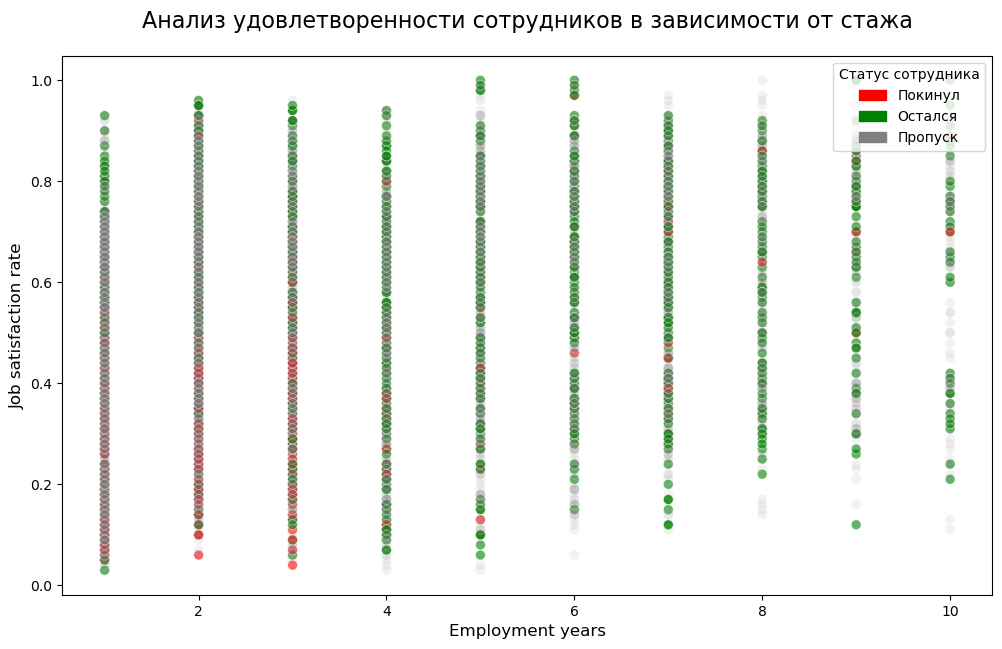

In [39]:
plot_numerical_distribution(
    df, 
    "employment_years", 
    title = "Анализ удовлетворенности сотрудников в зависимости от стажа"
)

- Сотрудники, которые работают в компании более 5 лет очень редко катастрофически недовольны своим рабочим местом.
- При этом заметно, что большое количество сотрудников начинают покидать компанию до 4 лет стажа в ней.

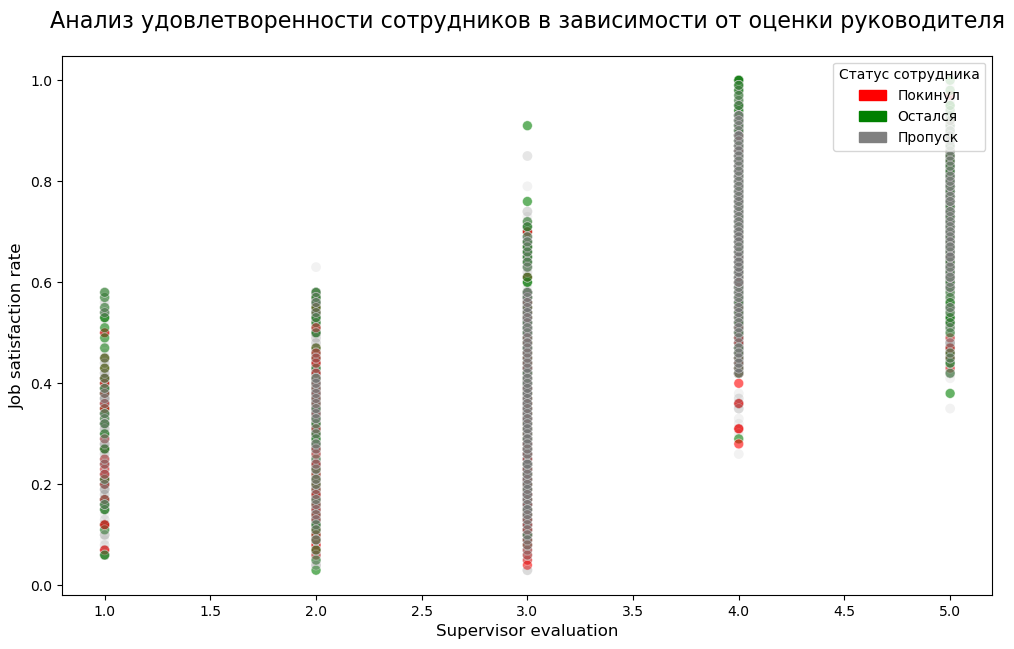

In [40]:
plot_numerical_distribution(
    df, 
    "supervisor_evaluation", 
    title = "Анализ удовлетворенности сотрудников в зависимости от оценки руководителя"
)

- Сотрудники с низкими оценками руководителей менее всего были довольны своей работой и чаще остальных покидали её.
- Для оценок от 3 и выше наблюдается прямая зависимость между удовлетворённостью сотрудника работой и оценкой его руководителя.
- Заметна логичная особенность "сотрудников-хорошистов" с 3 и 4 баллами по оценкам руководителей: при низкой их удовлетворённостю рабочим местом и относительно высоких оценках сотрудники чаще уходили из компании. При высокой же удовлетворённости и таких же оценках руководства "хорошисты" чащё оставались в компании. 

Можно предположить, что позитивные оценки руководства мотивируют сотрудников продолжать работать в компании далее, а негативные воспринимаются как токсичность.


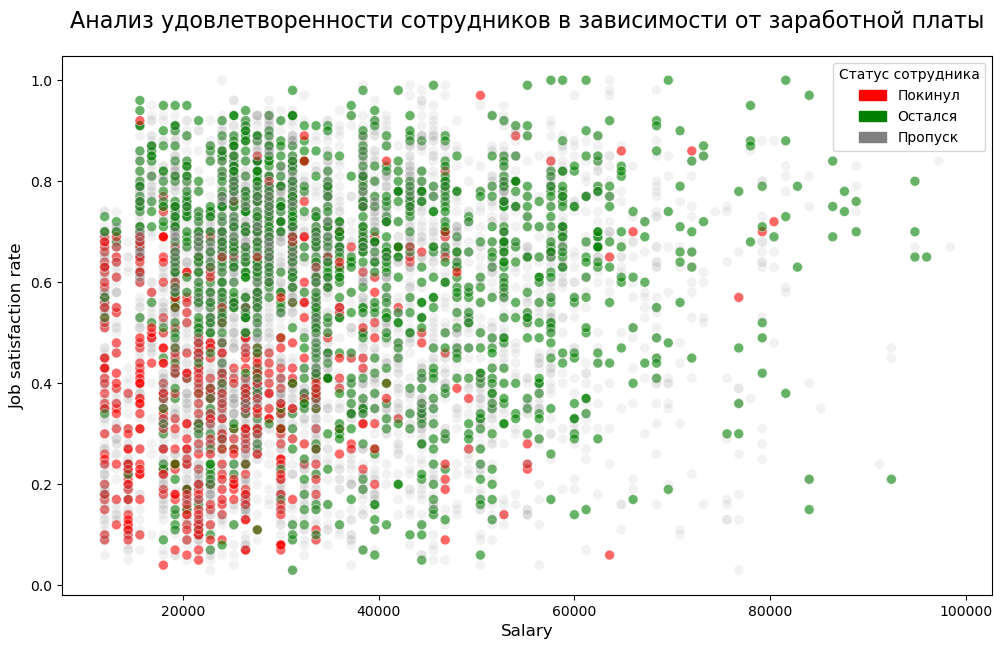

In [41]:
plot_numerical_distribution(
    df, 
    "salary", 
    title = "Анализ удовлетворенности сотрудников в зависимости от заработной платы"
)

- Заметно, что сотрудники с высокой удовлетворённостью рабочим местом чаще всего продолжают работу вне зависимости от их оплаты труда
- Низкая и умеренно-высокая удовлетворённость сотрудников работой в компании при условии оплаты труда менее 40_000 у.е. повышают риски того, что сотрудник прекратит работу в компании
- Заметно, что удовлетворённость сотрудников работой не зависит от оплаты труда

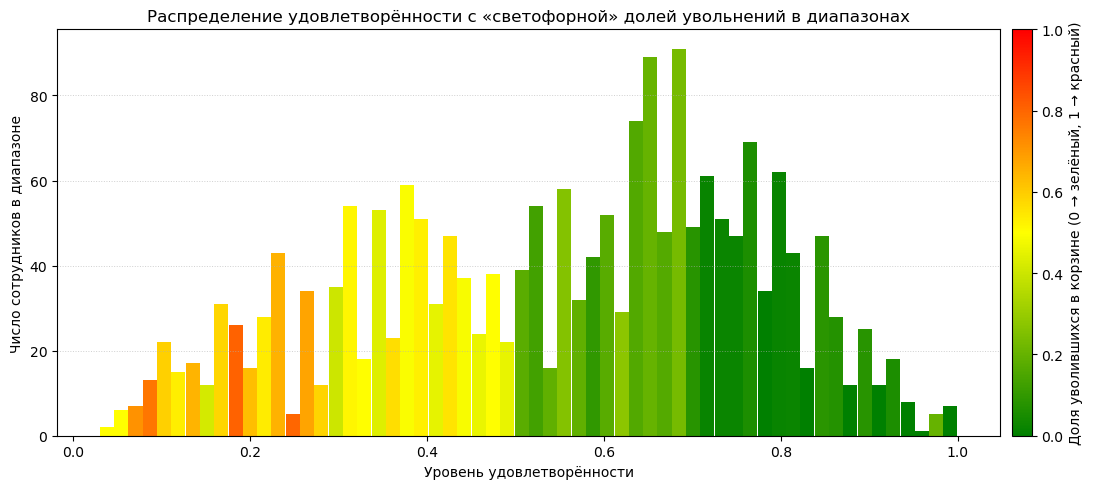

In [42]:
NUM_BINS = 60  

data = df[["job_satisfaction_rate", "quit"]].dropna(subset = ["job_satisfaction_rate", "quit"])
data["quit_bin"] = data["quit"].map({"no": 0.0, "yes": 1.0}).astype("float")

x_min, x_max = data["job_satisfaction_rate"].min(), data["job_satisfaction_rate"].max()
bins = np.linspace(x_min, x_max, NUM_BINS + 1)
bin_widths = np.diff(bins)
bin_centers = (bins[:-1] + bins[1:]) / 2

bin_idx = np.digitize(data["job_satisfaction_rate"].to_numpy(), bins, right = False) - 1
bin_idx = np.clip(bin_idx, 0, NUM_BINS - 1)

counts = np.zeros(NUM_BINS, dtype = int)
quit_mean = np.full(NUM_BINS, np.nan, dtype = float)

for i in range(NUM_BINS):
    mask = (bin_idx == i)
    if np.any(mask):
        counts[i] = mask.sum()
        quit_mean[i] = data.loc[mask, "quit_bin"].mean()

traffic_cmap = LinearSegmentedColormap.from_list("traffic", ["green", "yellow", "red"], N = 256)
norm = Normalize(vmin = 0.0, vmax = 1.0)

colors = traffic_cmap(norm(np.nan_to_num(quit_mean, nan = 0.5)))  

plt.figure(figsize = (12, 5))
plt.bar(bin_centers, counts, width = bin_widths * 0.98, color = colors, edgecolor = "none")

plt.xlabel("Уровень удовлетворённости")
plt.ylabel("Число сотрудников в диапазоне")
plt.title("Распределение удовлетворённости с «светофорной» долей увольнений в диапазонах")
plt.grid(axis = "y", linestyle = ":", linewidth = 0.7, alpha = 0.6)

sm = plt.cm.ScalarMappable(norm = norm, cmap = traffic_cmap)
sm.set_array([])
cbar = plt.colorbar(sm, pad = 0.01)
cbar.set_label("Доля уволившихся в корзине (0 → зелёный, 1 → красный)")

plt.tight_layout()
plt.show()


- Удовлетворённость сотрудника рабочим местом напрямую влияет на прололжение его работы в компании
- Вероятность ухода сотрудника резко падает при удовлетворённости ниже среднего
- График распределения частот удовлетворённости сотрудников мультимодален: неудовлетворённость сотрудников увеливичается до ~0.38 и далее падает до нейтрального уровня удовлетворённости. После нейтрального уровня удовлетворённость сотрудников резко повышается до ~0.68 и далее так же падает
- Чаще всего сотрудники умеренно удовлетворены своим рабочим местом

### Рассмотрим распределения для качественных признаков.

In [43]:
def plot_category_pie_with_satisfaction_rate(
    df: pd.DataFrame,
    category_col: str = "dept",
    satisfaction_col: str = "job_satisfaction_rate",
    top_n: int = 8,
    title: str = "Удовлетворённость работой по департаментам",
    red_hex: str = "#E74C3C",
    green_hex: str = "#2ECC71",
    others_label: str = "Другие",
    others_color: str = "#B0BEC5",
    explode_value: float = 0.05
):
    category_counts = df[category_col].value_counts()
    top_categories = category_counts.head(top_n)
    other_count = int(category_counts.iloc[top_n:].sum())
    has_others = other_count > 0

    if has_others:
        top_categories[others_label] = other_count

    satisfaction_by_cat = (
        df[[category_col, satisfaction_col]]
        .groupby(category_col)[satisfaction_col]
        .mean()
    )
    real_top_cats = [c for c in top_categories.index if c != others_label]
    real_means = satisfaction_by_cat.reindex(real_top_cats)
    vmin = float(np.nanmin(real_means.values)) if len(real_means) else 0.0
    vmax = float(np.nanmax(real_means.values)) if len(real_means) else 1.0

    if np.isclose(vmin, vmax):
        vmin -= 0.5
        vmax += 0.5

    norm = Normalize(vmin = vmin, vmax = vmax)
    cmap = LinearSegmentedColormap.from_list("satisfaction_cmap", ["#F39C12", "#F7DC6F", "#D4E157"])

    colors = []
    for cat in top_categories.index:
        if cat == others_label:
            colors.append(others_color)
        else:
            mean_val = satisfaction_by_cat.get(cat, np.nan)
            colors.append(cmap(norm(mean_val)))

    total = len(df)
    labels = []
    for cat, count in top_categories.items():
        pct = 100 * count / total if total > 0 else 0
        if cat == others_label:
            labels.append(f"{cat}\n({count} чел., {pct:.1f}%)")
        else:
            mean_val = satisfaction_by_cat.get(cat, np.nan)
            sat_txt = "н/д" if pd.isna(mean_val) else f"{mean_val:,.2f}".replace(",", " ")
            labels.append(f"{cat}\n({count} чел., {pct:.1f}% | ср. удовл.: {sat_txt})")

    explode = [explode_value] * len(top_categories)

    fig, ax = plt.subplots(figsize = (18, 10))
    wedges, texts, autotexts = ax.pie(
        top_categories.values,
        labels = labels,
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        explode = explode,
        shadow = True,
        textprops = {"fontsize": 10, "fontweight": "bold"},
        wedgeprops = dict(linewidth = 1, edgecolor = "white")
    )
    ax.set_title(title, fontsize = 14, fontweight = "bold", pad = 20)
    ax.axis("equal")

    sm = ScalarMappable(norm = norm, cmap = cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax = ax, fraction = 0.046, pad = 0.04, format = mtick.PercentFormatter(1, decimals = 1))
    cbar.set_label("Средняя удовлетворённость сотрудников (по департаменту)", fontsize = 11)

    plt.show()


C:\Users\yka\AppData\Local\Temp\ipykernel_21152\3621014611.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  without_empty_category["dept"] = without_empty_category["dept"].cat.remove_categories([' '])


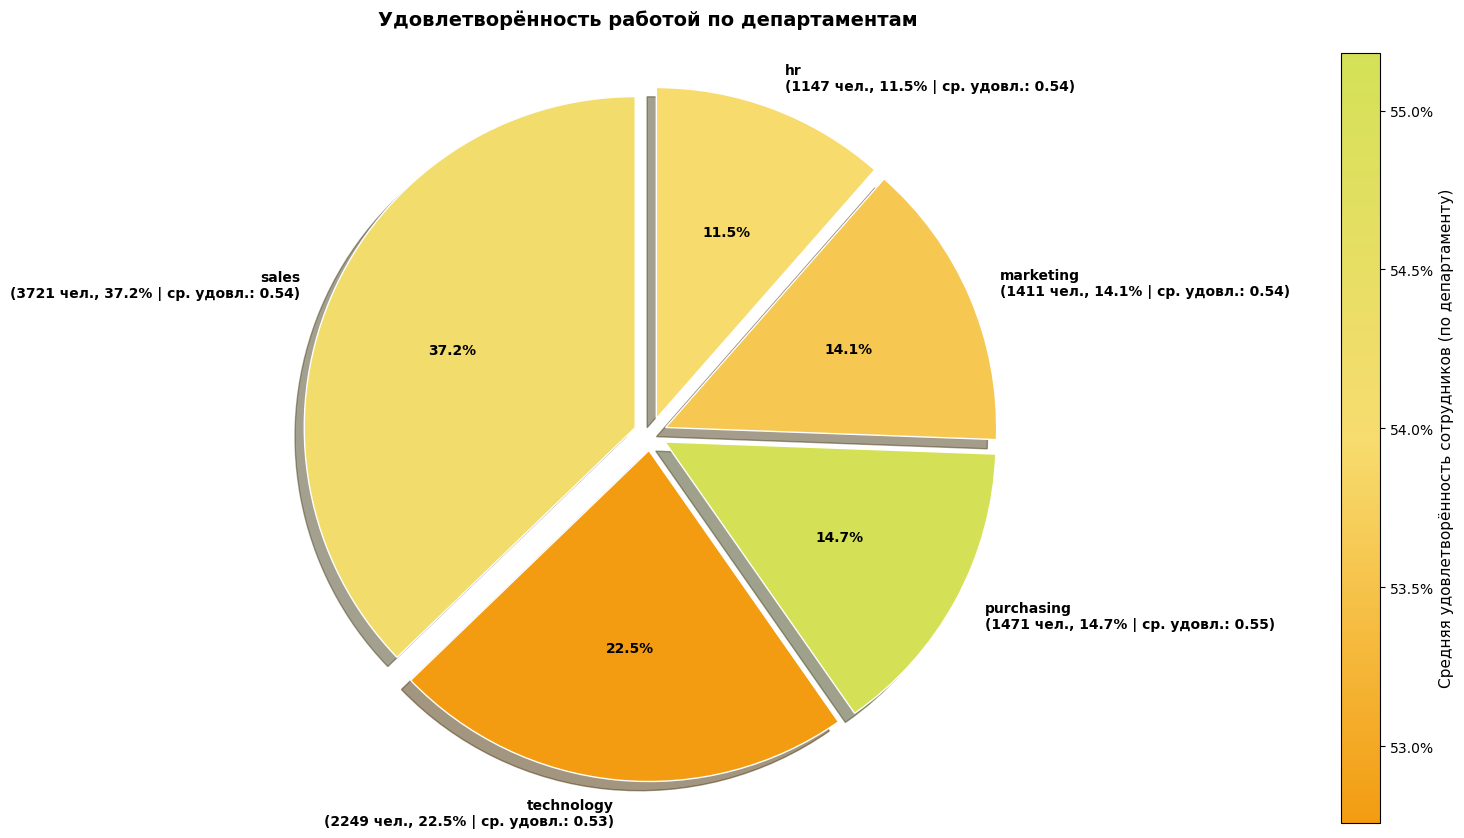

In [44]:
without_empty_category = df[df["dept"] != ' ']
without_empty_category["dept"] = without_empty_category["dept"].cat.remove_categories([' '])
plot_category_pie_with_satisfaction_rate(without_empty_category)

- Значения удовлетворённости сотрудников во всех департаментах незначительно выше среднего
- Колебания средней удовлетворённости в зависимости от отдела не более 2%
- Наименее удовлетворены работники технологического отдела
- Наиболее удовелетворены работники отдела закупок
- Больше трети сотрудников работают в отделе продаж
- Больше пятой части сотрудников работают в технологическом отделе
- В остальных отделах работает приблизительно равное количество сотрудников

В целом ясно, что компания занимается продажей товаров т.к. есть отдел закупок. Компания сосредоточила человеческие ресурсы на продажах и IT инфраструктуре для ведения бизнеса. Значительных различий в комфортности работы в различных департаментах не наблюдается

In [45]:
def plot_quit_grouped_bars(
    df: pd.DataFrame,
    category_col: str = "dept",
    ordered_categories: Optional[list] = None,
    quit_col: str = "quit",
    title: str = "Статус сотрудников по категориям",
    x_label: str = "Категория",
    green_hex: str = "#2ECC71",
    red_hex: str = "#E74C3C",
    alpha: float = 0.60,
    width: float = 0.42,
    rotation: int = 0
):
    tmp = df[[category_col, quit_col]].copy()
    tmp["status"] = tmp[quit_col].map({"no": "Остались", "yes": "Ушли"})
    tmp = tmp.dropna(subset = ["status", category_col])

    g = (
        tmp.groupby([category_col, "status"]).size()
        .unstack("status")
        .reindex(columns = ["Остались", "Ушли"])
    )
    if ordered_categories is not None:
        g = g.reindex(ordered_categories)
    g = g.fillna(0).astype(int)

    depts = g.index.tolist()
    stayed_counts = g["Остались"].values if "Остались" in g.columns else np.zeros(len(g))
    quit_counts = g["Ушли"].values if "Ушли" in g.columns else np.zeros(len(g))
    totals = stayed_counts + quit_counts
    stay_share = np.divide(stayed_counts, totals, out = np.zeros_like(stayed_counts, dtype = float), where = totals > 0) * 100.0
    quit_share = np.divide(quit_counts, totals, out = np.zeros_like(quit_counts, dtype = float), where = totals > 0) * 100.0
    x = np.arange(len(depts))

    fig, ax = plt.subplots(figsize = (18, 9))
    bars_stay = ax.bar(x - width / 2, stayed_counts, width, label = "Остались", color = green_hex, alpha = alpha)
    bars_quit = ax.bar(x + width / 2, quit_counts, width, label = "Ушли", color = red_hex, alpha = alpha)

    ax.bar_label(bars_stay, labels = [f"{v:.1f}%" for v in stay_share], padding = 3, fontsize = 9, fontweight = "bold")
    ax.bar_label(bars_quit, labels = [f"{v:.1f}%" for v in quit_share], padding = 3, fontsize = 9, fontweight = "bold")
    ax.set_xticks(x)
    ax.set_xticklabels(depts, rotation = rotation, ha = "center")
    ax.set_xlabel(x_label, fontsize = 12)
    ax.set_ylabel("Количество сотрудников", fontsize = 12)
    ax.set_title(title, fontsize = 14, fontweight = "bold", pad = 12)
    ax.grid(axis = "x", linestyle = "--", linewidth = 0.8, alpha = 0.8)
    ax.legend(frameon = False)

    fig.tight_layout()
    plt.show()


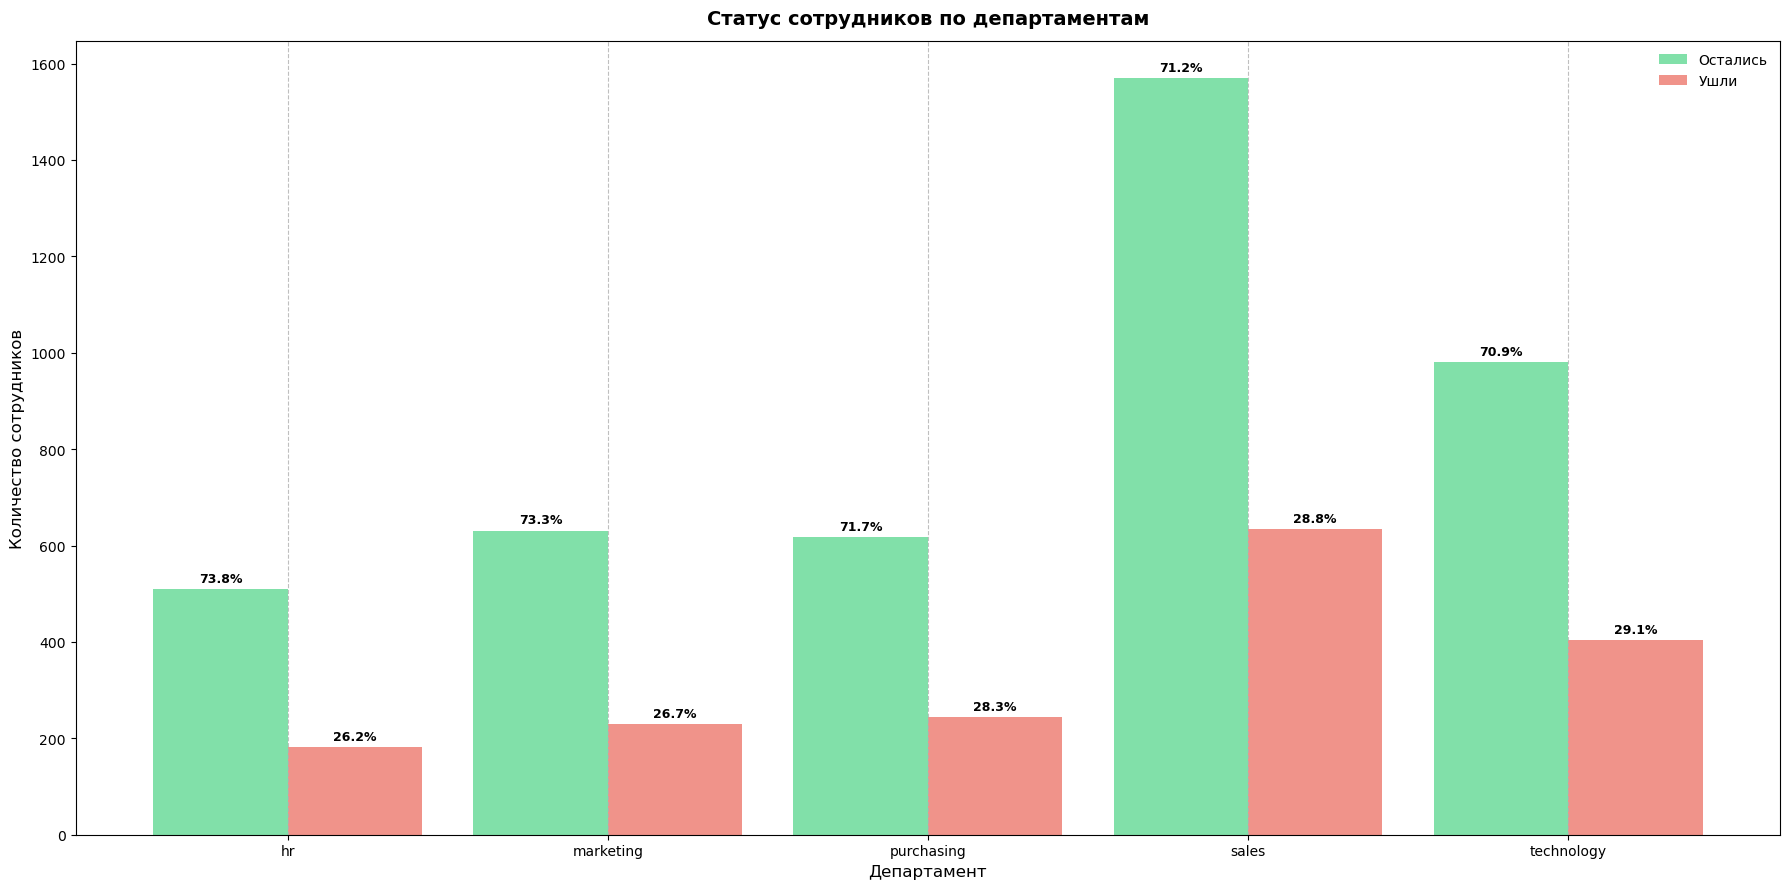

In [46]:
plot_quit_grouped_bars(without_empty_category,
    title = "Статус сотрудников по департаментам",
    x_label = "Департамент")

- Больше всего сотрудников уходит и в абсолютном (500+ человек) смысле из отдела продаж
- Относительно всех работающих в отделе сотрудников бошльше всего человек уходит из технологического отдела(29.5%) 
- Меньше всего сотрудников в относительном смысле уходит из HR отдела (24.1%)
- В любом из отделов примерно каждый четвёртый (или более) сотрудник покидает команду
- Разница между долей покинувших рабочее место сотрудников в лучшем и худшем департаменте составляет 2.9%

Текучка кадров в отделе продаж на допустимом уровне и на мой взгляд обусловлена спецификой работы в продажах. Информацию о технологическом отделе стоит внимательнее изучить HR'ам

In [47]:
def plot_ordered_category_bars(
    df: pd.DataFrame,
    category_col: str,
    ordered_categories: list,
    satisfaction_col: str = "job_satisfaction_rate",
    title: str = "Распределение сотрудников по категориям и удовлетворённости",
    x_label: str = "Категория",
    greenish_yellow_hex: str = "#D4E157",
    yellow_hex: str = "#F7DC6F",
    reddish_yellow_hex: str = "#F39C12",
    width: float = 0.7,
    alpha: float = 0.8,
    show_colorbar: bool = True
):
    counts = df.groupby(category_col).size().reindex(ordered_categories, fill_value = 0)
    means = df.groupby(category_col)[satisfaction_col].mean().reindex(ordered_categories)
    vals = means.values.astype(float)
    if np.all(np.isnan(vals)):
        vmin, vmax = 0.0, 1.0
    else:
        vmin = float(np.nanmin(vals))
        vmax = float(np.nanmax(vals))
    if np.isclose(vmin, vmax):
        vmin -= 0.5
        vmax += 0.5

    norm = Normalize(vmin = vmin, vmax = vmax)
    cmap = LinearSegmentedColormap.from_list("yellow_satisfaction", [reddish_yellow_hex, yellow_hex, greenish_yellow_hex])

    colors = []
    for m in means.values:
        if pd.isna(m):
            colors.append(yellow_hex)
        else:
            colors.append(cmap(norm(m)))

    total = float(counts.sum())
    pct_share = (counts.values.astype(float) / total * 100.0) if total > 0 else np.zeros_like(counts.values, dtype = float)

    x = np.arange(len(ordered_categories))
    fig, ax = plt.subplots(figsize = (16, 9))
    bars = ax.bar(x, counts.values.astype(float), width = width, color = colors, edgecolor = "white", linewidth = 1, alpha = alpha)

    ax.bar_label(bars, labels = [f"{v:.1f}%" for v in pct_share], padding = 3, fontsize = 9, fontweight = "bold")
    ax.set_xticks(x)
    ax.set_xticklabels(ordered_categories)
    ax.set_xlabel(x_label, fontsize = 12)
    ax.set_ylabel("Количество сотрудников", fontsize = 12)
    ax.set_title(title, fontsize = 14, fontweight = "bold", pad = 14)
    ax.grid(axis = "y", linestyle = "--", linewidth = 0.8, alpha = 0.5)
    ax.margins(x = 0.02)

    if show_colorbar:
        sm = ScalarMappable(norm = norm, cmap = cmap)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax = ax, fraction = 0.046, pad = 0.04, format = mtick.PercentFormatter(1, decimals = 1))
        cbar.set_label("Средняя удовлетворённость (по категории)", fontsize = 11)

    fig.tight_layout()
    plt.show()


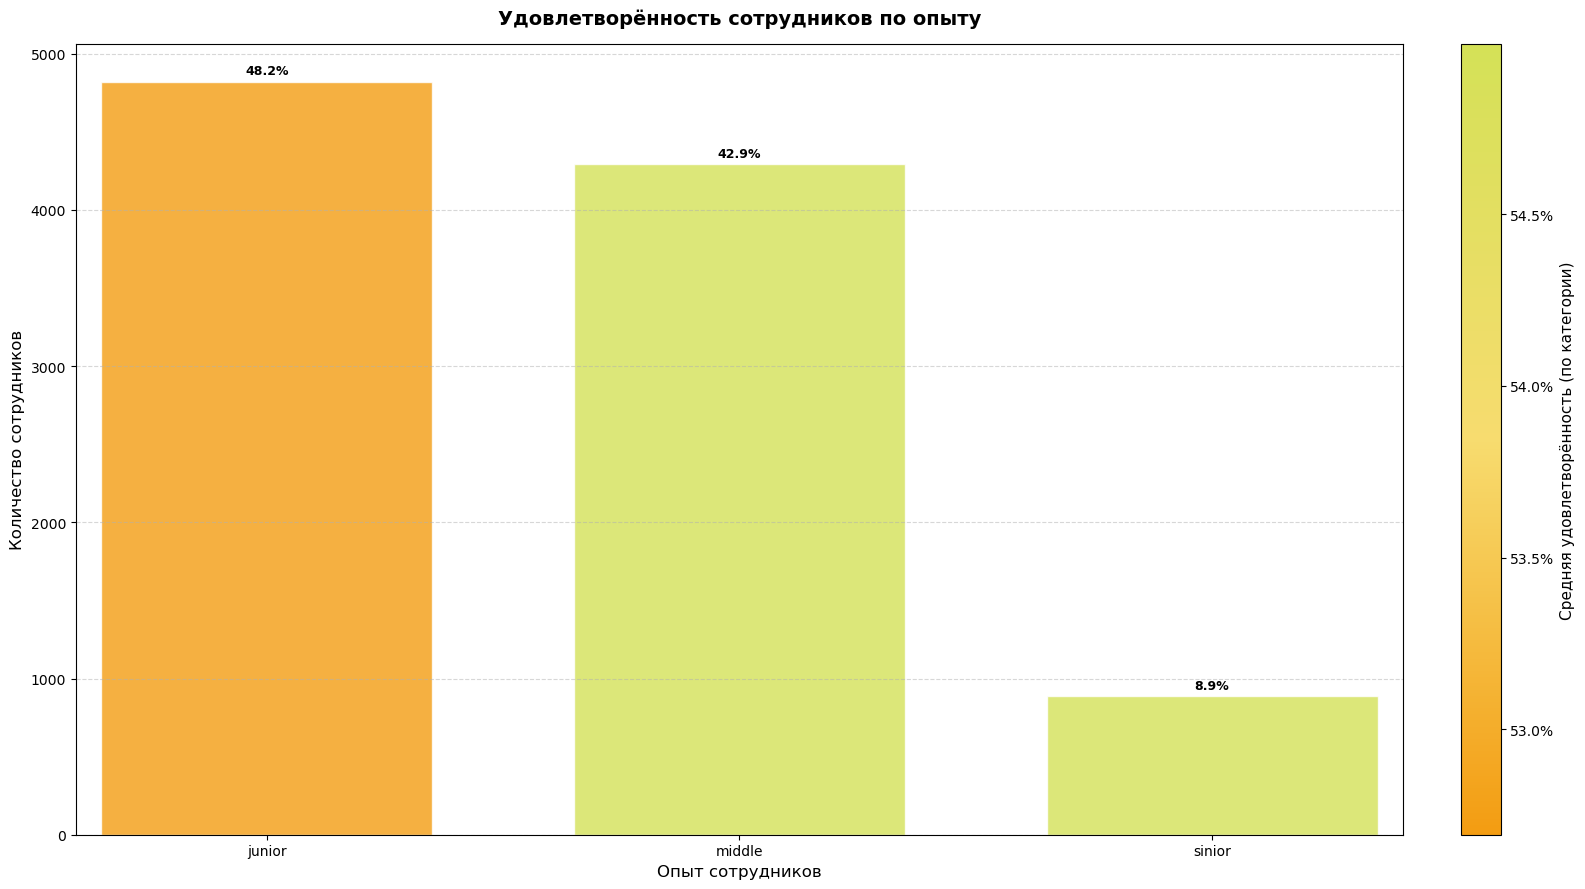

In [48]:
plot_ordered_category_bars(df,
    category_col = "level",
    ordered_categories = ["junior", "middle", "sinior"],
    title = "Удовлетворённость сотрудников по опыту",
    x_label = "Опыт сотрудников")

- Опытных сотрудников в компании более чем в 9 раз меньше, чем новичков и бывалых
- Новичков незначительно больше чем бывалых сотрудников
- Меньше всего довольны рабочими местами новички

Стоит лучше продумать процесс адаптации новых сотрудников т.к. среди них больше всего недовольных работой людей

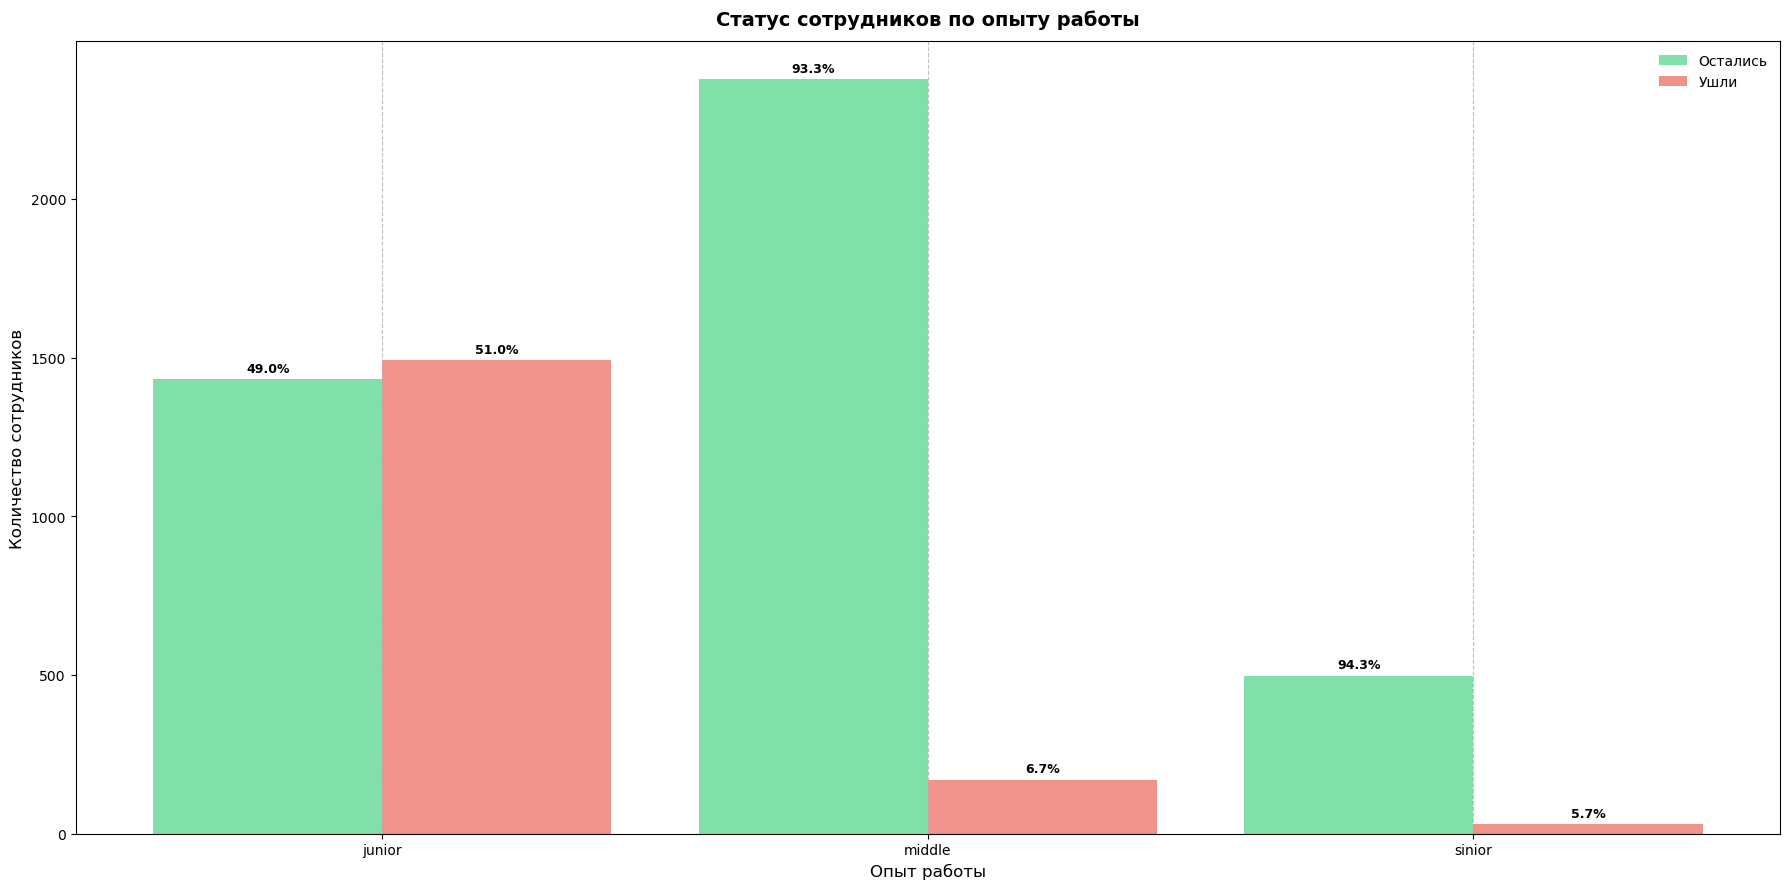

In [49]:
plot_quit_grouped_bars(df,
    category_col = "level",
    ordered_categories = ["junior", "middle", "sinior"],
    title = "Статус сотрудников по опыту работы",
    x_label = "Опыт работы")

- Чуть более половины новичков в профессии покидает компанию
- Доля опытных специалистов покидающих компанию более чем в 7 раз меньше и составляет чуть менее 7%

В целом, адекватные показатели текучки с учётом испытательных сроков и низкой текучки опытных сотрудников. Можно попробовать обратиться к рекрутёрам и ужесточить процесс отбора кандидаточ для снижения их оттока

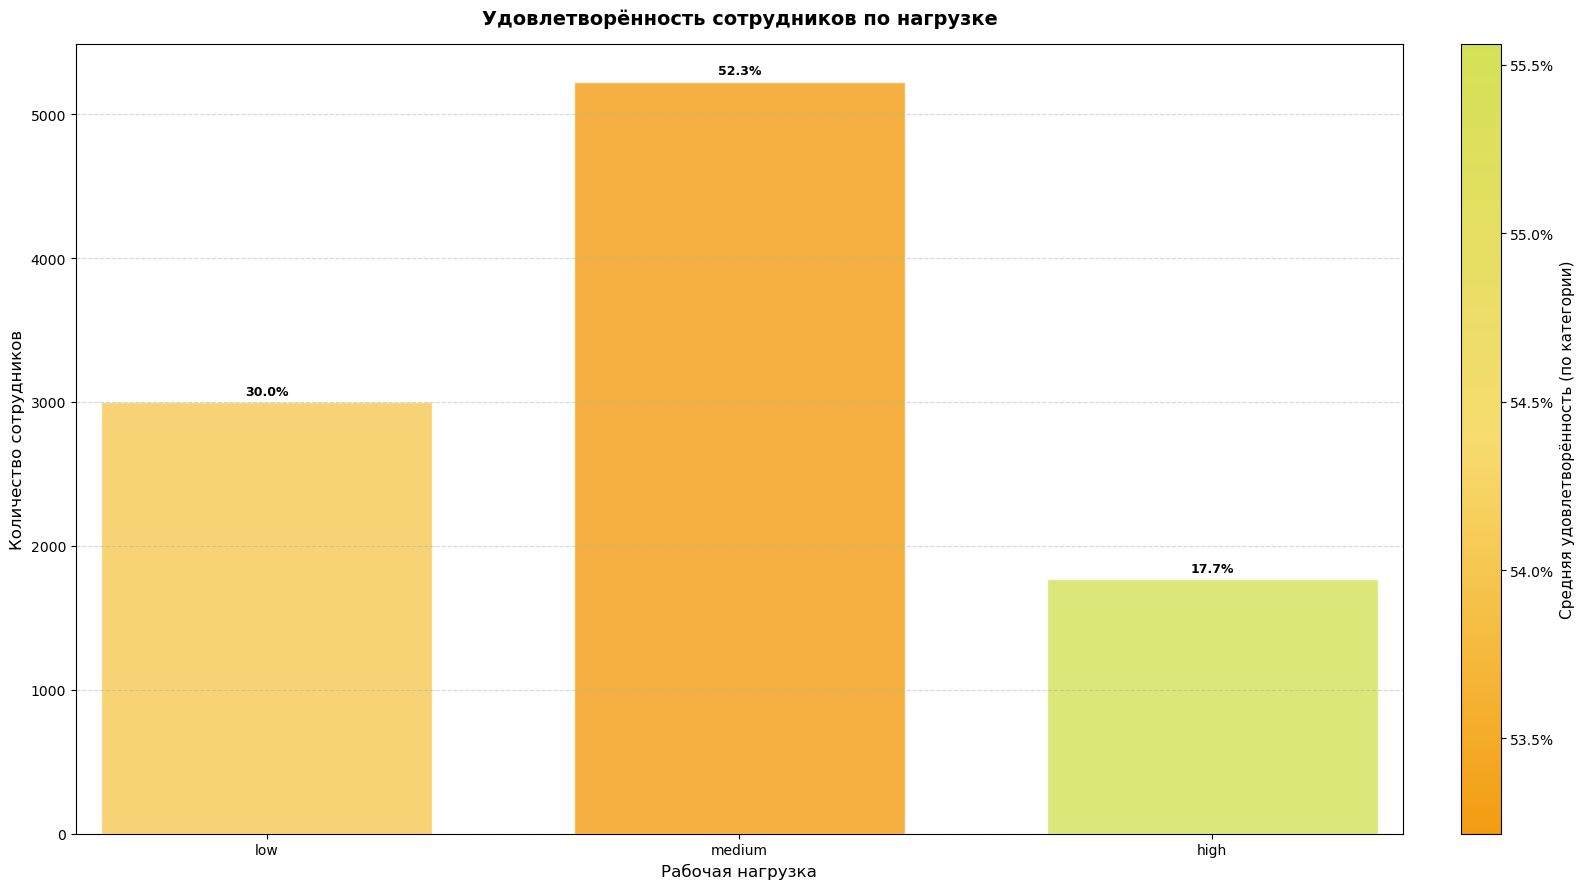

In [50]:
plot_ordered_category_bars(df,
    category_col = "workload",
    ordered_categories = ["low", "medium", "high"],
    title = "Удовлетворённость сотрудников по нагрузке",
    x_label = "Рабочая нагрузка")

- Парадоксально, но ~20% сотрудников, оценивших свою нагрузку как высокую более довольны своим местом работы в среднем
- ~50% сотрудников, имеющих среднюю нагрузку меньше всего довольны своим местом работы
- 30% сотрудников недогружены, есть потенциал к повышению производительности труда

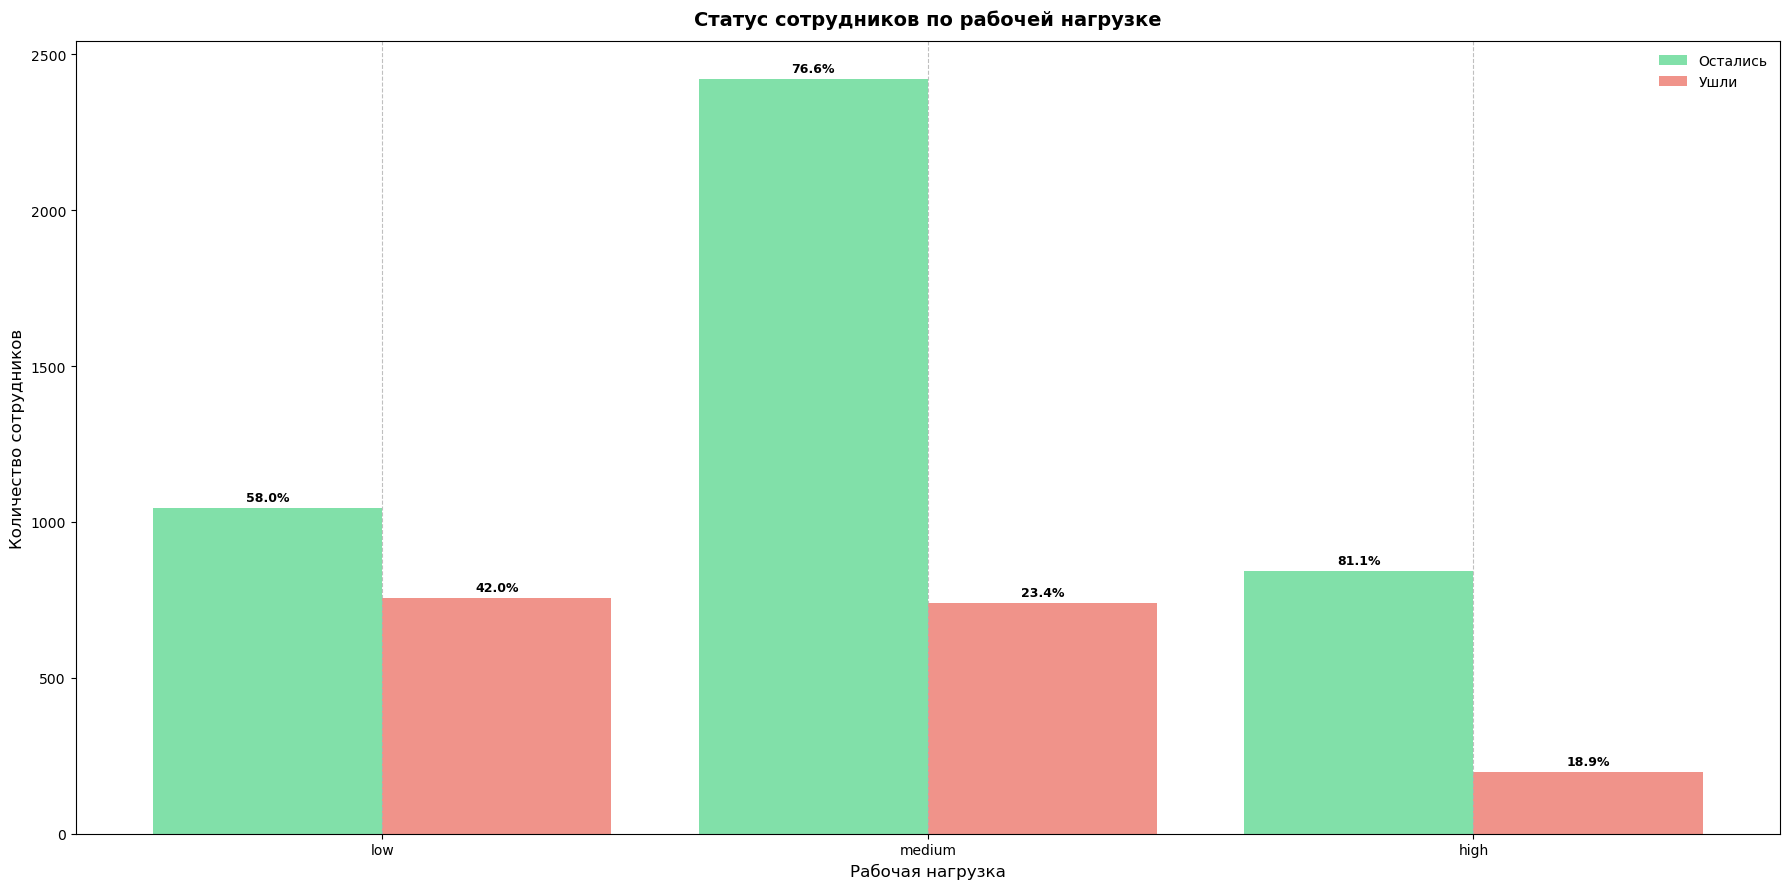

In [51]:
plot_quit_grouped_bars(df,
    category_col = "workload",
    ordered_categories = ["low", "medium", "high"],
    title = "Статус сотрудников по рабочей нагрузке",
    x_label = "Рабочая нагрузка")

Схожая с удовлетворённостью ситуация:

- Работники с низким уровнем нагрузки в 42% случаев покидают работу
- Работники с высоким уровнем нагрузки в ~2 реже покидают работу, чем малонагруженные коллеги
- Примерно четверть сотрудников со средним уровнем нагрузки покидает компанию

Высокий уровень нагрузки, вероятно, воспринимается сотрудниками как интересные вызовы и возможность развития, HR департаменту стоит детальнее изучить этот вопрос в рамках компании

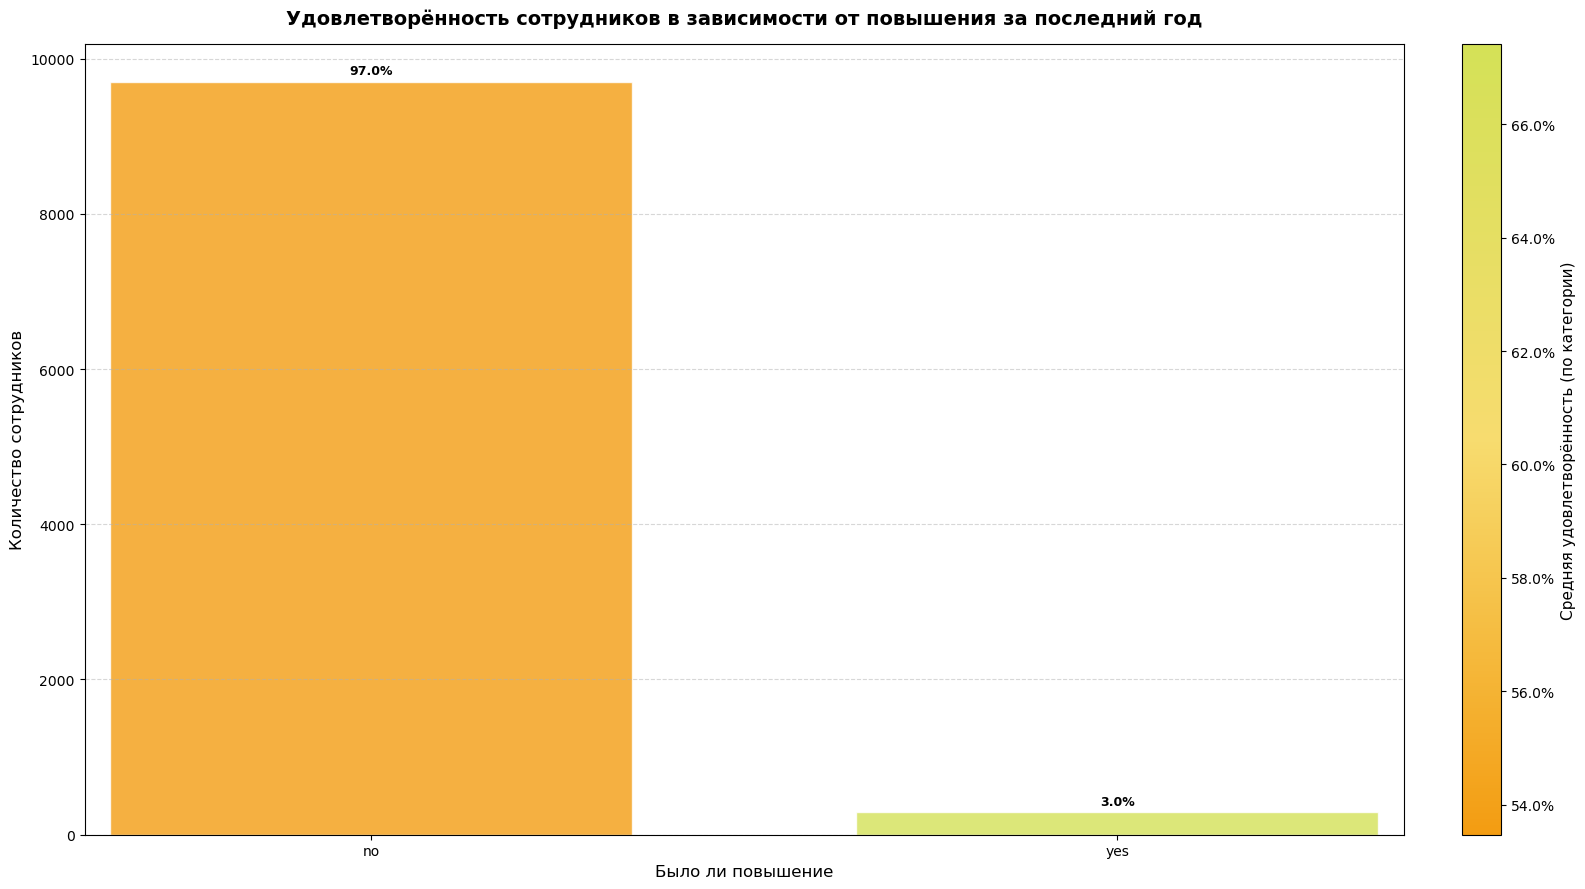

In [52]:
plot_ordered_category_bars(df,
    category_col = "last_year_promo",
    ordered_categories = ["no", "yes"],
    title = "Удовлетворённость сотрудников в зависимости от повышения за последний год",
    x_label = "Было ли повышение")

- Сотрудников, получивших повышение всего 3%
- Повышение значительно влияет на удовлетворённость сотрудников работой 

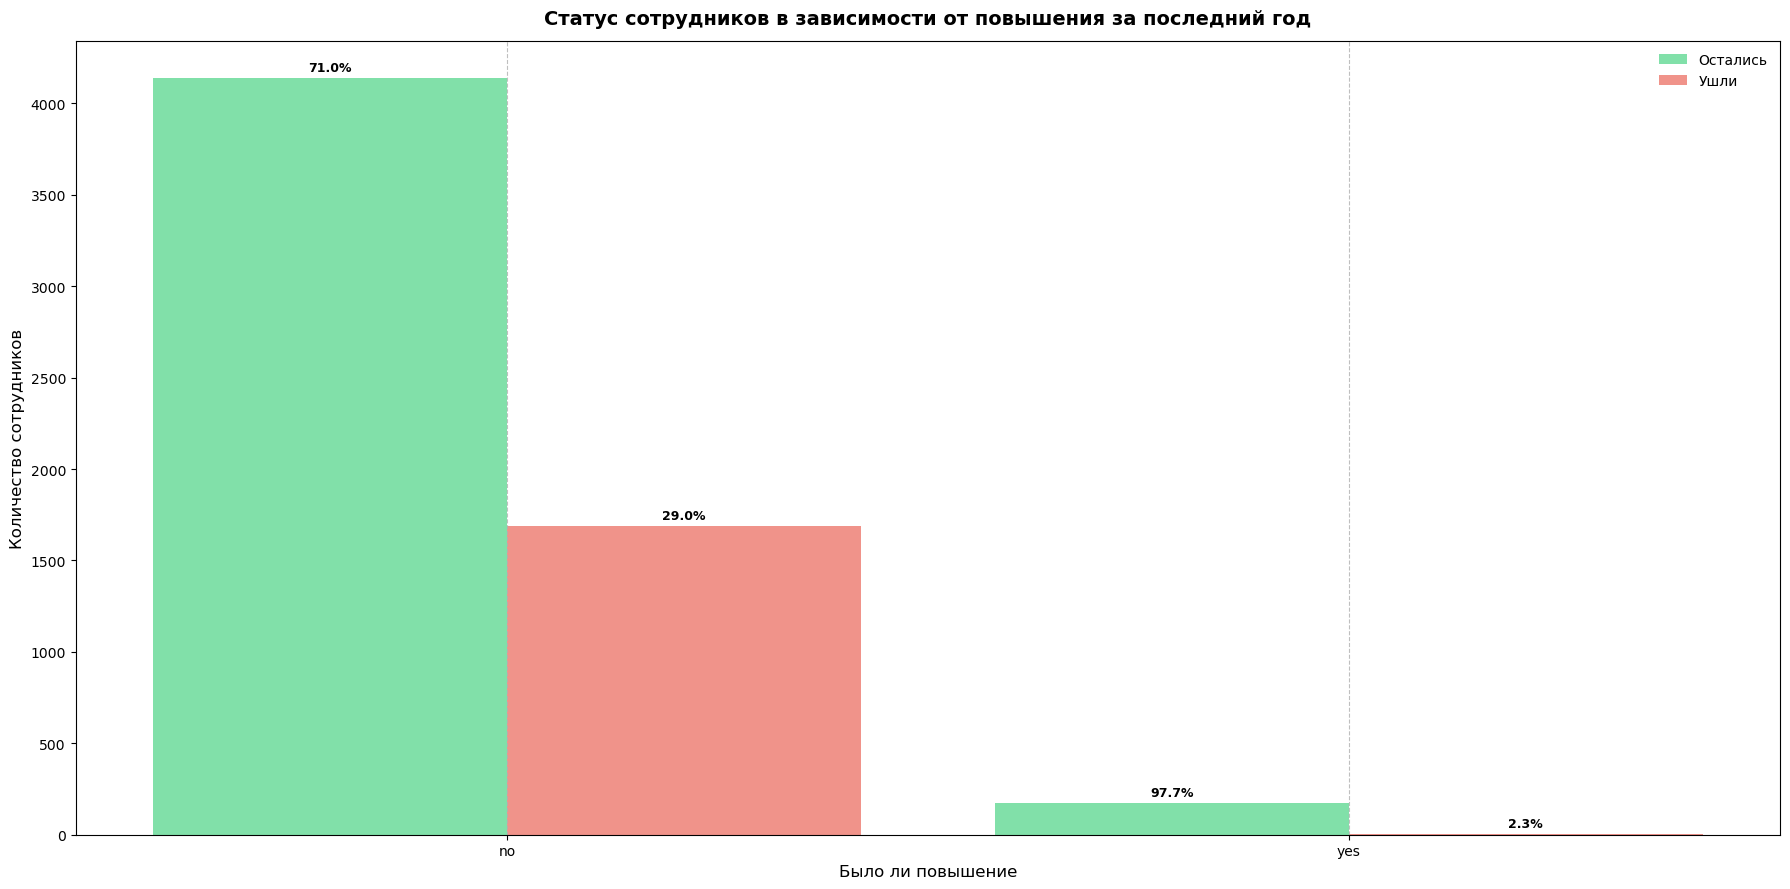

In [53]:
plot_quit_grouped_bars(df,
    category_col = "last_year_promo",
    title = "Статус сотрудников в зависимости от повышения за последний год",
    x_label = "Было ли повышение")

- Большинство сотрудников не получали повышения
- Повышение в ~12,6 раз уменьшает вероятность покидания сотрудником рабочего места

Есть смысл чаще мотивировать сотрудников, давая им незначительные повышения, как одну из стратегий удержания человеческого капитала в компании. При этом ключевых сотрудников стоит чаще повышать чтобы снизить риски ухода критически важных кадров.

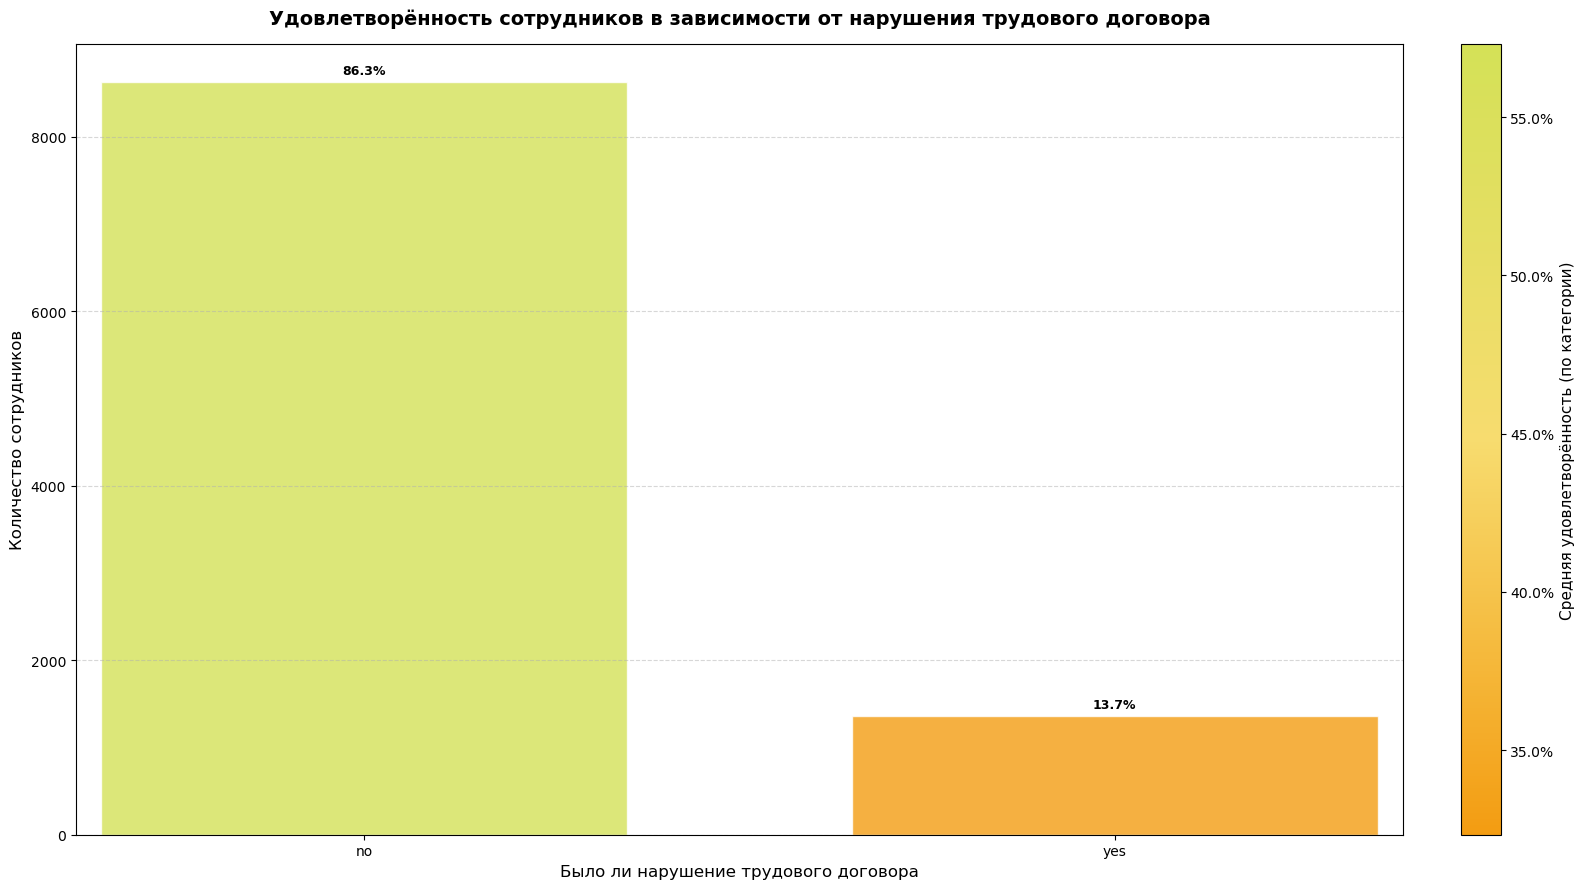

In [54]:
plot_ordered_category_bars(df,
    category_col = "last_year_violations",
    ordered_categories = ["no", "yes"],
    title = "Удовлетворённость сотрудников в зависимости от нарушения трудового договора",
    x_label = "Было ли нарушение трудового договора")

- Нарушивших трудовой договор более чем в 6 раз меньше
- Удовлетворённость работой нарушивших трудовой договор значительно меньше, чем у остальных сотрудников

Можно предположить, что сотрудники, неудовлетворённые своей работой склонны нарушать трудовой договор.

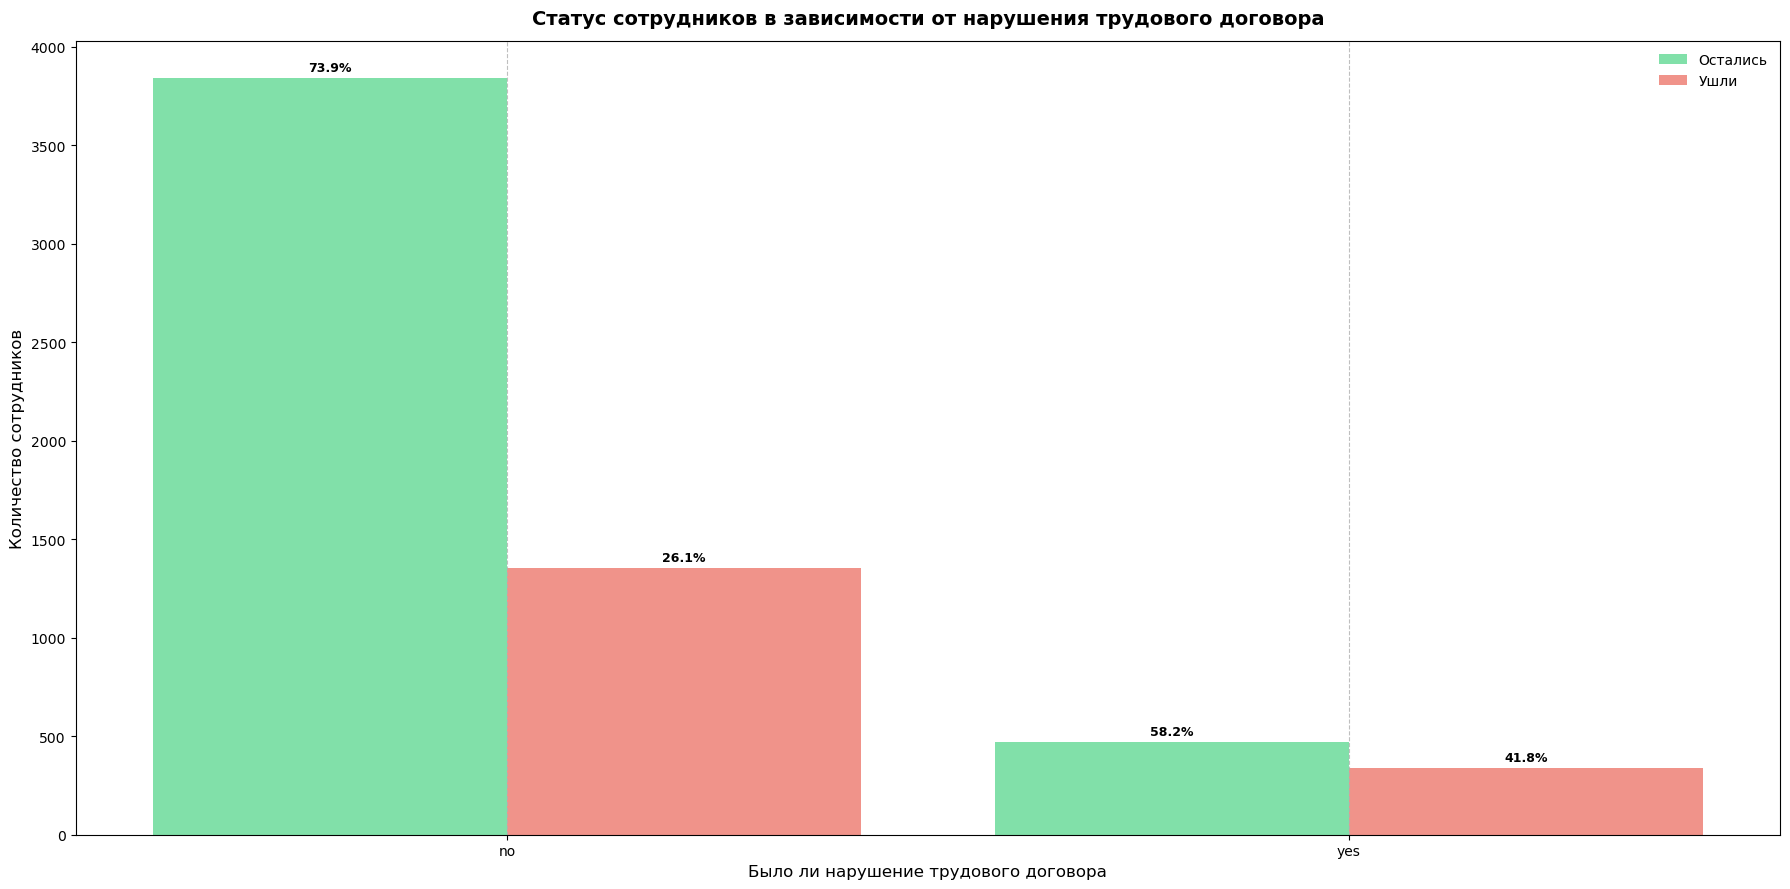

In [55]:
plot_quit_grouped_bars(df,
    category_col = "last_year_violations",
    title = "Статус сотрудников в зависимости от нарушения трудового договора",
    x_label = "Было ли нарушение трудового договора")

- Сотрудники, нарушившие трудовой договор почти в 2 раза чаще покидали компанию

Возможно, HR отделу стоит внимательнее изучить причинно-следственную связь между нарушением трудового договора и удовлетворённостью рабочим местом сотрудников компании. Появилась гипотеза, что низкая удовлетворённость работой в компании может быть причиной нарушения трудового договора и последующего покидания рабочего места в некоторых случаях

### Выводы EDA

**Промежуточный вывод**:

Провели ознакомление с данными сотрудников, значительных выбросов и аномалий найдено не было, сделали выводы о влиянии признаков на целевые показатели.

Замечания по связи с удовлетворённостью и вероятностью продолжения работы сотрудников:

- Сотрудники реже увольняются после 4 лет работы в компании
- Позитивные оценки руководства выше среднего позитивно влияют на удовлетворённость работой сотрудников
- Сотрудникам с высокой удовлетворённостью рабочим местом можно не повышать ЗП т.к. они с высокой вероятностью останутся. При этом недовольные сотрудники с ЗП ниже 40_000 скорее всего уйдут
- Важно следить за тем, чтобы удовлетворённость сотрудника работой оставалась выше 50% т.к. это резко понижает шансы ухода
- Значительных различий в комфортности работы в различных департаментах не наблюдается
- Стоит обратить внимание на текучку кадров в отделе продаж 
- Стоит лучше продумать процесс адаптации новых сотрудников т.к. среди них больше недовольных работой людей
- Сотрудникам стоит давать более сложные задачи т.к. это понижает вероятность ухода и одновременно может повысить производительность труда
- Появилась гипотеза, что низкая удовлетворённость работой в компании может быть причиной нарушения трудового договора и последующего покидания рабочего места в некоторых случаях. HR отделу стоит детальнее изучить этот процес в динамике
- Есть смысл чаще мотивировать сотрудников, давая им незначительные повышения, как одну из стратегий удержания человеческого капитала в компании
- Ключевых сотрудников стоит регулярно поощрять повышениями для снижения риска их ухода

## Корреляционный анализ

### Корреляционная матрица

Для начала построим кореляционную матрицу в виде тепловой карты.

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


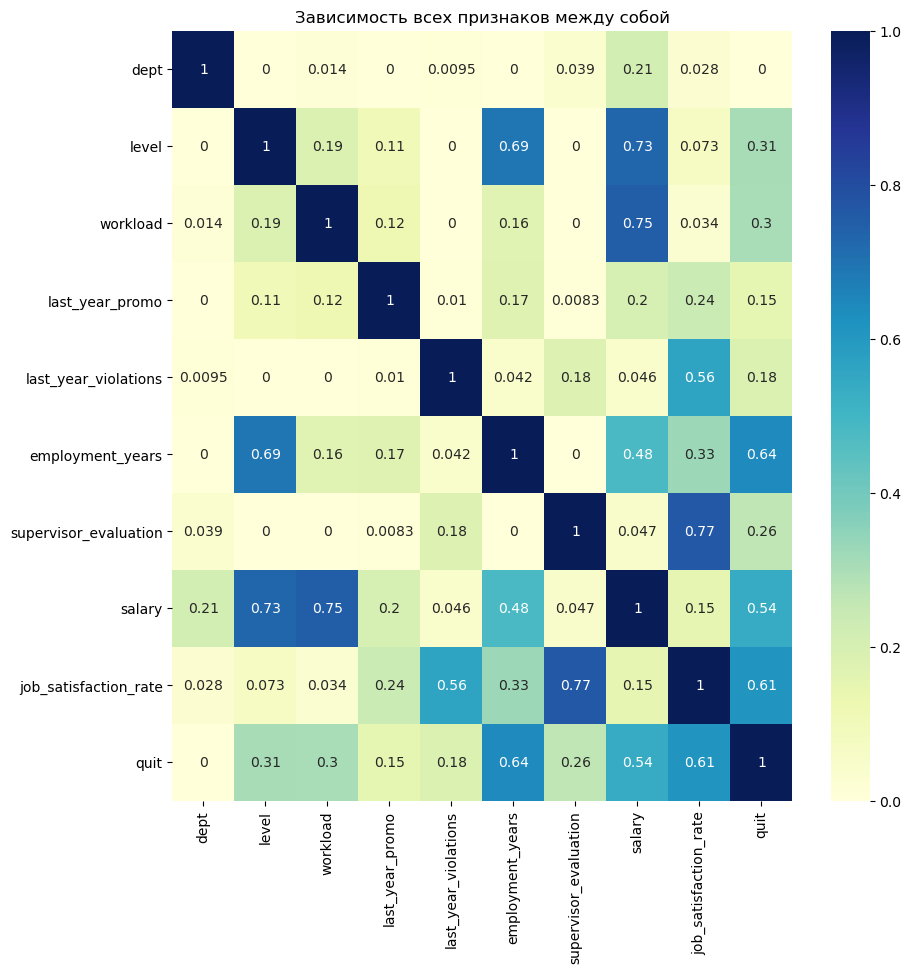

In [56]:
numeric_columns = df.select_dtypes(include = ["number"]).columns.tolist()
numeric_columns.remove("id")
fig, ax = plt.subplots(figsize=(10,10))  
phi_k = df.drop("id", axis = 1).phik_matrix()
sns.heatmap(phi_k, cmap = "YlGnBu", annot = True)
ax.set_title("Зависимость всех признаков между собой")
plt.show()

### VIF (коэффициент инфляции дисперсии)

Оценим мультиколлинеарность каждого не содержащего пропусков численного признака в данных при помощи рассчёта коэффициента инфляции дисперсии

In [57]:
df[numeric_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   employment_years       10000 non-null  int64  
 1   supervisor_evaluation  10000 non-null  int64  
 2   salary                 10000 non-null  int64  
 3   job_satisfaction_rate  6000 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 390.6 KB


In [58]:
complete_data = df[df["job_satisfaction_rate"].notna()]
X = add_constant(complete_data[numeric_columns])
VIFs = pd.DataFrame()
VIFs["Variable"] = X.columns
VIFs["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(VIFs.sort_values(by = "VIF", ascending = False))

,Variable,VIF
0,const,18.233315
4,job_satisfaction_rate,2.119877
2,supervisor_evaluation,2.023674
1,employment_years,1.354461
3,salary,1.277115


Исходя из корелляционной матрицы и анализа VIF делаем вывод, что мультиколлинеарность в количественных данных отсутствует. Наиболее скоррелированным с удовлетворённостью работой является оценка руководителя.

Заметим также, что наиболее скореллированы с уходом из компании стаж и удовлетворённость рабочим местом сотрудников. При этом связь удовлетворённости и вероятности ухода, как заметили ранее в EDA, не линейна.

## Построение пайплайна регрессии

### Подготовка данных

На данном этапе в подготовке данных к ML нужно учитывать, что в данных могут присутствовать некорректные категории. Например, символ пробела, встреченный во время предобработки или иные. Для обработки таких значениё без искажения предсказаний будем игнорировать такие значения и присваивать им нулевые веса.

In [59]:
y_train = X_train_js["job_satisfaction_rate"]
X_train = X_train_js.drop(["id", "job_satisfaction_rate"], axis = 1)

ohe_columns = ["dept", "last_year_promo", "last_year_violations"]
ord_columns = ["level", "workload"]
numeric_columns = X_train.select_dtypes(include = ["number"]).columns.tolist()

cat_ohe_pipe = Pipeline([
    ("impute", SimpleImputer(strategy = "most_frequent")),
    ("ohe", OneHotEncoder(drop = "if_binary",
                          handle_unknown = "ignore"))
])

cat_ord_pipe = Pipeline([
    ("impute", SimpleImputer(strategy = "most_frequent")),
    ("ord", OrdinalEncoder(handle_unknown = "use_encoded_value",
                           unknown_value = 3))
])

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy = "mean")),
    ("scale", MinMaxScaler())
])

data_preprocessor = ColumnTransformer(
    transformers=[
        ("cat_ohe", cat_ohe_pipe, ohe_columns),
        ("cat_ord", cat_ord_pipe, ord_columns),
        ("num", num_pipe, numeric_columns),
    ],
    remainder="passthrough"
)

### Cоздадим итоговый пайплайн регрессии

In [60]:
regress_pipe = Pipeline([
    ("preprocessor", data_preprocessor),
    ("models", LinearRegression(n_jobs = -1))
])

param_grid = [
    {
        'models': [LinearRegression(n_jobs = -1)],
        'preprocessor__num__scale': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), 'passthrough']  
    },
    {
        "models": [KNeighborsRegressor(n_jobs = -1)],
        "models__n_neighbors": range(2, 7),
        "models__weights": ["uniform", "distance"],
        "models__algorithm": ["ball_tree", "kd_tree"],
        "models__leaf_size": range(2, 51, 3),
        "models__metric": ["euclidean", "manhattan"],
        "preprocessor__num__scale": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]   
    },
    {
        "models": [ElasticNet(
            random_state=RANDOM_STATE
        )],
        "models__alpha": [.5, 1, 2, 5, 10],
        "models__l1_ratio": [.4, .5, .6],
        "preprocessor__num__scale": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]  
    },
    {
        "models": [SVR()],
        "models__C": [1, 2, 4, 8, 16, 32],
        "models__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "models__degree": [2, 3, 4, 5],
        "models__gamma": ["scale", "auto"],
        "preprocessor__num__scale": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]  
    },
    {
        "models": [DecisionTreeRegressor(
            random_state=RANDOM_STATE
        )],
        "models__criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
        "models__max_depth": range(2, 11),
        "models__min_samples_split": range(2, 10),
        "models__min_samples_leaf": range(2, 51, 2),
        "models__max_features": ["sqrt", "log2"],
        "preprocessor__num__scale": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]  
    }
]

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype = float)
    y_pred = np.asarray(y_pred, dtype = float)
    denom = np.abs(y_true) + np.abs(y_pred)
    ratio = np.where(denom == 0.0, 0.0, np.abs(y_true - y_pred) / (denom / 2.0))
    return 100.0 * np.sum(ratio) / len(y_true)

smape_scorer = make_scorer(smape, greater_is_better = False) 
randomized_search = RandomizedSearchCV(
    regress_pipe, 
    param_grid,
    n_iter = 250,
    cv = 5,
    scoring = smape_scorer,
    random_state = RANDOM_STATE,
    n_jobs = -1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_ohe',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('cat_ord',
                                                                               Pipeline(steps=[('impu...
                                                               'absolute_error',
                                                               'poisson'],
                                         'models__max_depth': range(2, 11),
                                         'models__max_features': ['sqrt',
                                                                  'log2'],
                                         'models__min_samples_leaf': range(2, 51, 2),
                                         'models__min_samples_split': range(2, 10),
                                         'preprocessor__num__scale': [StandardScaler(),
                                                                      MinMaxScaler(),
                                                                      RobustScaler(),
                                                                      MaxAbsScaler(),
                                                                      'passthrough']}],
                   random_state=1,
                   scoring=make_scorer(smape, greater_is_better=False))

### Оценка качества регрессии

Сопоставим индексы признаков тестовой выборки.

In [61]:
test_regress = pd.merge(X_test, y_test_regress, on = "id")
X_test_regress = test_regress.drop(["id", "job_satisfaction_rate"], axis = 1)
y_test_regress = test_regress["job_satisfaction_rate"]

Для задачи выбрана метрика SMAPE по желанию заказчика.

In [62]:
display("Лучшая модель и её параметры:", randomized_search.best_estimator_)
display("Метрика лучшей модели на тренировочной выборке:", abs(randomized_search.best_score_))
display(f"Метрика SMAPE на тестовой выборке: {abs(smape_scorer(randomized_search.best_estimator_, X_test_regress, y_test_regress))}")

'Лучшая модель и её параметры:'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ohe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('cat_ord',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=3))]),
                                                  ['level', 'workload']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models', SVR(C=1, degree=4))])

'Метрика лучшей модели на тренировочной выборке:'

15.087325410075504

c:\Users\yka\AppData\Local\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


'Метрика SMAPE на тестовой выборке: 14.58518377718969'

In [63]:
randomized_search.best_estimator_.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('cat_ohe',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ohe',
                                                     OneHotEncoder(drop='if_binary',
                                                                   handle_unknown='ignore'))]),
                                    ['dept', 'last_year_promo',
                                     'last_year_violations']),
                                   ('cat_ord',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ord',
                                                     OrdinalEncoder(han

### Вывод подбора модели регрессии

**Наилучшей** моделью оказалась **модель опорных векторов** с параметром C = 1 и нелинейным ядром 4 степени **SMAPE близок к 15** на тестовой выборке. Такое значение точности выглядит правдоподобным и удовлетворительным

### Анализ важности признаков регрессии

Т.к. лучшей оказалась нелинейная модель, используем метод важности перестановки признаков для анализа их значимости

In [64]:
r = permutation_importance(randomized_search.best_estimator_, X_test_regress, y_test_regress,
                           n_repeats = 30,
                           random_state = RANDOM_STATE)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        display(f"{X_test_regress.columns.to_list()[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

c:\Users\yka\AppData\Local\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\yka\AppData\Local\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\yka\AppData\Local\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\yka\AppData\Local\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warning

'salary  1.596 +/- 0.039'

'level   1.106 +/- 0.029'

'supervisor_evaluation1.034 +/- 0.025'

'workload0.641 +/- 0.014'

'employment_years0.251 +/- 0.008'

'dept    0.120 +/- 0.005'

'last_year_violations0.103 +/- 0.004'

'last_year_promo0.025 +/- 0.002'

Больше всего на уровень удовлетворённости сотрудника влияют:
1) Уровень заработной платы
2) Опыт работы сотрудника
3) Оценка эффективности сотрудника руководством

Меньше всего на удовлетворённость влияют:
1) Повышение за последний год
2) Нарушения трудового договора за последний год
3) Принадлежность к департаменту

### Выводы построения модели оценки удовлетворённости сотрудников

Лучше всего с задачей регрессии справилась нелинейная модель. Как видно из оценки важности признаков, наиболее важным для удовлетворённости работой в компании сотрудников оказался размер заработной платы. На этапе EDA мы убедились в отсутствии линейной зависимости этих признаков. По этой причине логично, что нелинейная модель оказалась лучшей. Ей хватило обобщающей силы для выделения основной зависимости с заработной платой.

## Построение пайплайна классификации

### Создание personality уволившегося сотрудника 

Частично, мы уже составили "портрет уволившегося сотрудника" в общем блоке EDA. Создадим финальный образ.

In [65]:
quit_mean_salary = df.query("quit == 'yes'")["salary"].mean()
stayed_mean_salary = df.query("quit == 'no'")["salary"].mean()

display(f"Средняя ЗП ушедших сотрудников: ~{round(quit_mean_salary)}",
    f"Средняя ЗП оставшихся сотрудников: ~{round(stayed_mean_salary)}")

'Средняя ЗП ушедших сотрудников: ~24242'

'Средняя ЗП оставшихся сотрудников: ~37683'

"Портрет уволившегося сотрудника":

- Работает в компании менее 4 лет
- Имеет оценку руководилетя по пятибальной системе ниже 3
- Имеет коэффициент удовлетворённости работой ниже 0.6 и при этом ЗП ниже 40_000 у.е.
- Работает в технологическом отделе либо отделе продаж
- Имеет малый профессиональный опыт
- Недогружен работой
- Не был повышен за последний год
- Нарушал трудовой договор за последний год

### Изучение связи удовлетворённости и ухода с работы

Ранее уже была выявлена и проанализирована связь между удовлетворённостью работой и уходом сотрудников. Напомним

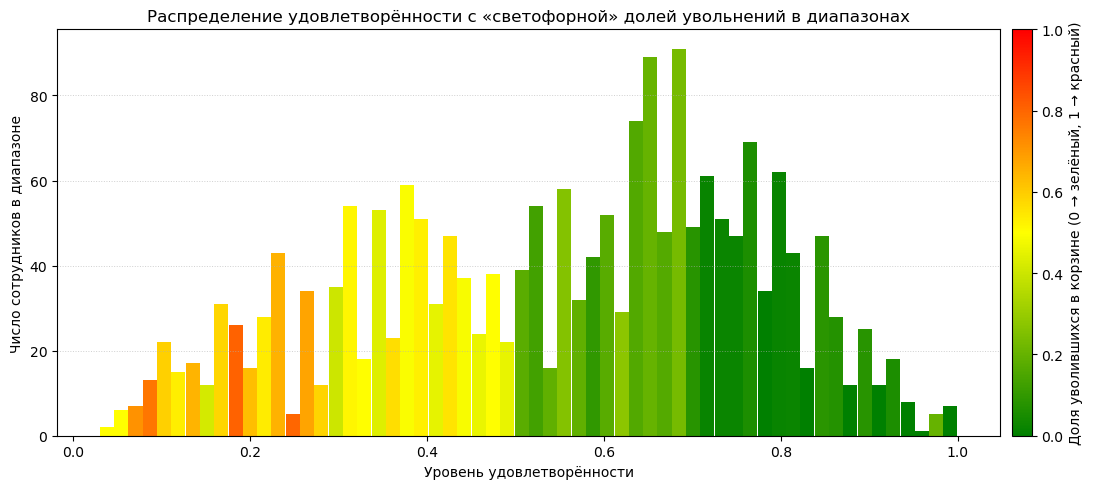

In [66]:
data = df[["job_satisfaction_rate", "quit"]].dropna(subset = ["job_satisfaction_rate", "quit"])
data["quit_bin"] = data["quit"].map({"no": 0.0, "yes": 1.0}).astype("float")

x_min, x_max = data["job_satisfaction_rate"].min(), data["job_satisfaction_rate"].max()
bins = np.linspace(x_min, x_max, NUM_BINS + 1)
bin_widths = np.diff(bins)
bin_centers = (bins[:-1] + bins[1:]) / 2

bin_idx = np.digitize(data["job_satisfaction_rate"].to_numpy(), bins, right = False) - 1
bin_idx = np.clip(bin_idx, 0, NUM_BINS - 1)

counts = np.zeros(NUM_BINS, dtype = int)
quit_mean = np.full(NUM_BINS, np.nan, dtype = float)

for i in range(NUM_BINS):
    mask = (bin_idx == i)
    if np.any(mask):
        counts[i] = mask.sum()
        quit_mean[i] = data.loc[mask, "quit_bin"].mean()

traffic_cmap = LinearSegmentedColormap.from_list("traffic", ["green", "yellow", "red"], N = 256)
norm = Normalize(vmin = 0.0, vmax = 1.0)

colors = traffic_cmap(norm(np.nan_to_num(quit_mean, nan = 0.5)))  

plt.figure(figsize = (12, 5))
plt.bar(bin_centers, counts, width = bin_widths * 0.98, color = colors, edgecolor = "none")

plt.xlabel("Уровень удовлетворённости")
plt.ylabel("Число сотрудников в диапазоне")
plt.title("Распределение удовлетворённости с «светофорной» долей увольнений в диапазонах")
plt.grid(axis = "y", linestyle = ":", linewidth = 0.7, alpha = 0.6)

sm = plt.cm.ScalarMappable(norm = norm, cmap = traffic_cmap)
sm.set_array([])
cbar = plt.colorbar(sm, pad = 0.01)
cbar.set_label("Доля уволившихся в корзине (0 → зелёный, 1 → красный)")

plt.tight_layout()
plt.show()

- **Удовлетворённость** сотрудника рабочим местом **напрямую влияет на прололжение его работы в компании**
- Вероятность ухода сотрудника резко падает при удовлетворённости ниже среднего
- График распределения частот удовлетворённости сотрудников мультимодален: неудовлетворённость сотрудников увеливичается до ~0.38 и далее падает до нейтрального уровня удовлетворённости. После нейтрального уровня удовлетворённость сотрудников резко повышается до ~0.7 и далее так же падает
- Чаще всего сотрудники умеренно удовлетворены своим рабочим местом

### Подготовим данные к обучению модели

Добавим предсказания удовлетворённостью рабочим местом в набор признаков

In [67]:
X_train_q["job_satisfaction_rate"] = randomized_search.best_estimator_.predict(X_train)
X_train_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     4000 non-null   int64   
 1   dept                   4000 non-null   category
 2   level                  4000 non-null   category
 3   workload               4000 non-null   category
 4   employment_years       4000 non-null   int64   
 5   last_year_promo        4000 non-null   category
 6   last_year_violations   4000 non-null   category
 7   supervisor_evaluation  4000 non-null   int64   
 8   salary                 4000 non-null   int64   
 9   quit                   4000 non-null   category
 10  job_satisfaction_rate  4000 non-null   float64 
dtypes: category(6), float64(1), int64(4)
memory usage: 180.6 KB


### Cоздадим итоговый пайплайн классификации

Выберем рандомным поиском наилучшую модель классификации, её гиперпараметры и улучшим её качество адаптивным бустингом. ETA обучения ~ 4 минуты.

In [68]:
y_train = X_train_q["quit"]
X_train = X_train_q.drop(["id", "quit"], axis = 1)

ohe_columns = ["dept", "last_year_promo", "last_year_violations"]
ord_columns = ["level", "workload"]
numeric_columns = X_train.select_dtypes(include = ["number"]).columns.tolist()

cat_ohe_pipe = Pipeline([
    ("impute", SimpleImputer(strategy = "most_frequent")),
    ("ohe", OneHotEncoder(drop = "if_binary",
                          handle_unknown = "ignore"))
])

cat_ord_pipe = Pipeline([
    ("impute", SimpleImputer(strategy = "most_frequent")),
    ("ord", OrdinalEncoder(handle_unknown = "use_encoded_value",
                           unknown_value = 3))
])

target_pipe = Pipeline([
    ("impute", SimpleImputer(strategy = "most_frequent")),
    ("trg", OrdinalEncoder(handle_unknown = "use_encoded_value",
                           unknown_value = 3))
])

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy = "mean")),
    ("scale", MinMaxScaler())
])

data_preprocessor = ColumnTransformer(
    transformers=[
        ("cat_ohe", cat_ohe_pipe, ohe_columns),
        ("cat_ord", cat_ord_pipe, ord_columns),
        ("num", num_pipe, numeric_columns),
    ],
    remainder="passthrough"
)

classif_pipeline = Pipeline([
    ("preprocessor", data_preprocessor),
    ("classifier", AdaBoostClassifier(random_state = RANDOM_STATE, n_estimators = 7))
])

param_distributions = [
    {
        "classifier__base_estimator": [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        "classifier__base_estimator__max_depth": [1, 3, 5],
        "classifier__base_estimator__min_samples_leaf": [1, 5, 10],
        "classifier__learning_rate": [.5, 1, 2],
        "preprocessor__num__scale": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]
    },
    {
        "classifier__base_estimator": [LogisticRegression(penalty = "elasticnet", solver = "saga", max_iter = 1000, random_state = RANDOM_STATE)],
        "classifier__base_estimator__C": [.1, .5, 1, 2, 5, 10],
        "classifier__base_estimator__l1_ratio": [0.1, 0.5, 0.9],
        "preprocessor__num__scale": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]
    },
    {
        "classifier__base_estimator": [SVC(probability=True, kernel='rbf', random_state=0)],
        "classifier__base_estimator__C": [.1, .5, 1, 2, 5, 10],
        "classifier__base_estimator__kernel": ["poly", "rbf", "sigmoid"],
        "classifier__base_estimator__degree": range(1, 6),
        "classifier__base_estimator__gamma": ["scale", .1, 1],
        "preprocessor__num__scale": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]
    }
]

search = RandomizedSearchCV(
    estimator = classif_pipeline,
    param_distributions = param_distributions,
    n_iter = 30,
    cv = 3,
    scoring = "roc_auc",
    n_jobs = -1,
    random_state = RANDOM_STATE
)

search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_ohe',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('cat_ord',
                                                                               Pipeline(steps=[('impu...
                                         'classifier__base_estimator__C': [0.1,
                                                                           0.5,
                                                                           1, 2,
                                                                           5,
                                                                           10],
                                         'classifier__base_estimator__degree': range(1, 6),
                                         'classifier__base_estimator__gamma': ['scale',
                                                                               0.1,
                                                                               1],
                                         'classifier__base_estimator__kernel': ['poly',
                                                                                'rbf',
                                                                                'sigmoid'],
                                         'preprocessor__num__scale': [StandardScaler(),
                                                                      MinMaxScaler(),
                                                                      RobustScaler(),
                                                                      MaxAbsScaler(),
                                                                      'passthrough']}],
                   random_state=1, scoring='roc_auc')

### Оценка качества классификации

Сопоставим индексы признаков тестовой выборки и добавим предсказание удовлетворённости рабочим местом к тестовой выборке

In [69]:
y_test_classif = test["quit"]
X_test_classif = test.drop(["id", "quit"], axis = 1)

Для задачи выбрана метрика ROC AUC по желанию заказчика

In [70]:
display("Лучшая модель и её параметры:", search.best_estimator_)
display("Метрика лучшей модели на тренировочной выборке:", search.best_score_)

y_test_classif_pred = search.predict_proba(X_test_classif)[:,1]

display(f"Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_classif, y_test_classif_pred)}")

'Лучшая модель и её параметры:'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ohe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('cat_ord',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_f...
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=3))]),
                                                  ['level', 'workload']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MaxAbsScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate'])])),
                ('classifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                          random_state=1),
                                    learning_rate=1, n_estimators=7,
                                    random_state=1))])

'Метрика лучшей модели на тренировочной выборке:'

0.9183642277863125

c:\Users\yka\AppData\Local\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


'Метрика ROC-AUC на тестовой выборке: 0.9133076265829037'

In [71]:
search.best_estimator_.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('cat_ohe',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ohe',
                                                     OneHotEncoder(drop='if_binary',
                                                                   handle_unknown='ignore'))]),
                                    ['dept', 'last_year_promo',
                                     'last_year_violations']),
                                   ('cat_ord',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ord',
                                                     OrdinalEncoder(han

### Вывод подбора модели классификации

Лучше всего подошла модель дерева решений с глубиной 1

## Итоговые выводы

### Задача

Была поставлена **задача** построения модели для **предсказания удовлетворённости сотрудников** и **предсказания их ухода из компании**.

### Подготовка данных

- Импортированы модули, фреймворки и библиотеки
- Проверено наличие явных дубликатов
- Преобразованы типы данных к наиболее подходящим
- С помощью пайплайна найдены и устранены пропуски в данных
- Данные проверены на наличие описок
- Данные обхединены в один набор для EDA

### EDA

Замечания по связи с удовлетворённостью и вероятностью продолжения работы сотрудников:

- Сотрудники реже увольняются после 4 лет работы в компании
- Позитивные оценки руководства выше среднего позитивно влияют на удовлетворённость работой сотрудников
- Сотрудникам с высокой удовлетворённостью рабочим местом можно не повышать ЗП т.к. они с высокой вероятностью останутся. При этом недовольные сотрудники с ЗП ниже 40_000 скорее всего уйдут
- Важно следить за тем, чтобы удовлетворённость сотрудника работой оставалась выше 50% т.к. это резко понижает шансы ухода
- Значительных различий в комфортности работы в различных департаментах не наблюдается

### Поиск модели

Для поиска лучших моделей были **опробованы 5 алгоритмов регрессии** и **3 алгоритма классификации с адаптивным бустингом** **с разными наборами** целесообразных **гиперпараметров** случайным образом.

### Лучшие модели

В качестве **лучшей модели предсказания удовлетворённости сотрудника** была получена модель **опорных векторов** с метрикой SMAPE близкой к **15**.

В качестве **лучшей модели предсказания ухода сотрудника** была получена модель **дерева решений** с метрикой ROC AUC близкой к **0.91**.

### **Идеи удержания сотрудников**

- Стоит обратить внимание на текучку кадров в отделе продаж 
- Стоит лучше продумать процесс адаптации новых сотрудников т.к. среди них больше недовольных работой людей
- Сотрудникам стоит давать более сложные задачи т.к. это понижает вероятность ухода и одновременно может повысить производительность труда
- Появилась гипотеза, что низкая удовлетворённость работой в компании может быть причиной нарушения трудового договора и последующего покидания рабочего места в некоторых случаях. HR отделу стоит детальнее изучить этот процес в динамике
- Есть смысл чаще мотивировать сотрудников, давая им незначительные повышения, как одну из стратегий удержания человеческого капитала в компании
- Ключевых сотрудников стоит регулярно поощрять повышениями для снижения риска их ухода.